In [1]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#This file is for development. Main functions are embedded here.

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt


from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos.ref"

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
#MSParameters.molecular_search.usedAtoms['S'] = (0,0)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

In [2]:
#Read in sample list and load MS data

samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')

MSfiles={}
for file in samplelist['File'][samplelist['type']=='sample']:
#for file in samplelist.File:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

print(samplelist)

samplelist=samplelist[samplelist['File'].isin(MSfiles.keys())]

                            File          type  run order  Sample number  \
0     RMB_190828_BATS01_100m.raw  other_sample          4            1.0   
1       RMB_190828_BATS02_5m.raw  other_sample          5            2.0   
2       RMB_190828_BATS03_5m.raw  other_sample          6            3.0   
3     RMB_190828_BATS04_250m.raw  other_sample          7            4.0   
4     RMB_190828_BATS05_300m.raw        sample          8            5.0   
5     RMB_190828_BATS06_400m.raw        sample          9            6.0   
6     RMB_190828_BATS07_500m.raw        sample         10            7.0   
7     RMB_190828_BATS08_100m.raw        sample         11            8.0   
8     RMB_190828_BATS09_200m.raw        sample         13            9.0   
9     RMB_190828_BATS10_800m.raw        sample         14           10.0   
10   RMB_190828_BATS11_1000m.raw        sample         15           11.0   
11      RMB_190828_BATS12_5m.raw        sample         16           12.0   
12     RMB_1

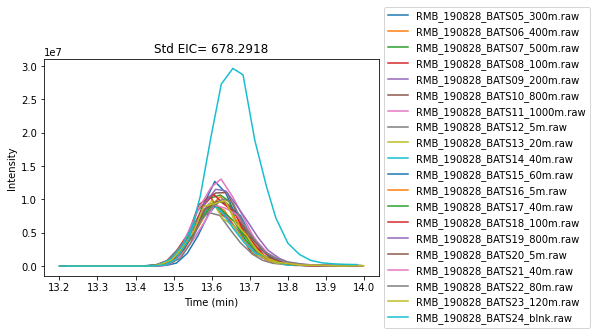

19
pass of
20
12.3 % std dev


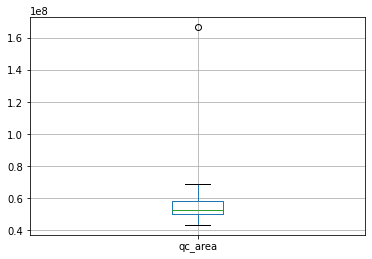

In [3]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

In [4]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[4,26]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(0, 2.0),
                                                    calib_snr_threshold=4)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [44]:
#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_4.csv')

RMB_190828_BATS05_300m.raw
MS Obj loaded - 332 peaks found.
MS Obj loaded - 332 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  887.56 ms


Loading molecular formula database: 84098it [00:07, 11088.12it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 114.61it/s]


'run_molecular_formula'  9452.60 ms
283 assigned peaks and 49 unassigned peaks, total  = 85.24 %, relative abundance = 73.49 %, RMS error (best candidate) (ppm) = 0.068
MS Obj loaded - 496 peaks found.
MS Obj loaded - 496 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
48 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  187.29 ms


Loading molecular formula database: 84098it [00:06, 12458.72it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 86.91it/s]


'run_molecular_formula'  8188.93 ms
454 assigned peaks and 42 unassigned peaks, total  = 91.53 %, relative abundance = 86.01 %, RMS error (best candidate) (ppm) = 0.072
MS Obj loaded - 622 peaks found.
MS Obj loaded - 622 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
56 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 692 fn evals and 15 iterations
'runworker'  522.16 ms


Loading molecular formula database: 84098it [00:06, 12600.76it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.83it/s]


'run_molecular_formula'  9119.68 ms
589 assigned peaks and 33 unassigned peaks, total  = 94.69 %, relative abundance = 93.67 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 570 peaks found.
MS Obj loaded - 570 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
57 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 784 fn evals and 17 iterations
'runworker'  178.13 ms


Loading molecular formula database: 84098it [00:08, 10051.40it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 73.55it/s]


'run_molecular_formula'  10017.68 ms
557 assigned peaks and 13 unassigned peaks, total  = 97.72 %, relative abundance = 98.28 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 606 peaks found.
MS Obj loaded - 606 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
78 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  474.00 ms


Loading molecular formula database: 84098it [00:05, 14990.39it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 102.35it/s]


'run_molecular_formula'  7152.13 ms
584 assigned peaks and 22 unassigned peaks, total  = 96.37 %, relative abundance = 91.83 %, RMS error (best candidate) (ppm) = 0.070
MS Obj loaded - 717 peaks found.
MS Obj loaded - 717 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
105 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3019 fn evals and 69 iterations
'runworker'  424.63 ms


Loading molecular formula database: 84098it [00:07, 11040.29it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.94it/s]


'run_molecular_formula'  9731.71 ms
704 assigned peaks and 13 unassigned peaks, total  = 98.19 %, relative abundance = 98.16 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 774 peaks found.
MS Obj loaded - 774 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
121 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 3007 fn evals and 71 iterations
'runworker'  153.69 ms


Loading molecular formula database: 84098it [00:06, 12893.96it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 81.71it/s]


'run_molecular_formula'  7999.81 ms
758 assigned peaks and 16 unassigned peaks, total  = 97.93 %, relative abundance = 97.26 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 860 peaks found.
MS Obj loaded - 860 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
141 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 3022 fn evals and 70 iterations
'runworker'  136.22 ms


Loading molecular formula database: 84098it [00:05, 14275.86it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 73.56it/s]


'run_molecular_formula'  7514.00 ms
842 assigned peaks and 18 unassigned peaks, total  = 97.91 %, relative abundance = 98.31 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 895 peaks found.
MS Obj loaded - 895 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
125 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 3038 fn evals and 68 iterations
'runworker'  129.69 ms


Loading molecular formula database: 84098it [00:06, 13944.09it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 76.14it/s]


'run_molecular_formula'  7585.12 ms
847 assigned peaks and 48 unassigned peaks, total  = 94.64 %, relative abundance = 94.81 %, RMS error (best candidate) (ppm) = 0.051
MS Obj loaded - 896 peaks found.
MS Obj loaded - 896 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3025 fn evals and 66 iterations
'runworker'  137.02 ms


Loading molecular formula database: 84098it [00:06, 13580.38it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 72.03it/s]


'run_molecular_formula'  7822.20 ms
842 assigned peaks and 54 unassigned peaks, total  = 93.97 %, relative abundance = 93.59 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1528 peaks found.
MS Obj loaded - 1528 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
161 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.052 ppm
minimize function performed 463 fn evals and 10 iterations
'runworker'  131.32 ms


Loading molecular formula database: 84098it [00:06, 13221.47it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


'run_molecular_formula'  9141.48 ms
1128 assigned peaks and 400 unassigned peaks, total  = 73.82 %, relative abundance = 88.38 %, RMS error (best candidate) (ppm) = 0.072
RMB_190828_BATS06_400m.raw
MS Obj loaded - 353 peaks found.
MS Obj loaded - 353 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  277.00 ms


Loading molecular formula database: 84098it [00:04, 17131.27it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 95.10it/s]


'run_molecular_formula'  6325.52 ms
313 assigned peaks and 40 unassigned peaks, total  = 88.67 %, relative abundance = 80.69 %, RMS error (best candidate) (ppm) = 0.075
MS Obj loaded - 438 peaks found.
MS Obj loaded - 438 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
40 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 858 fn evals and 20 iterations
'runworker'  619.00 ms


Loading molecular formula database: 84098it [00:06, 12940.15it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 111.21it/s]


'run_molecular_formula'  8133.12 ms
404 assigned peaks and 34 unassigned peaks, total  = 92.24 %, relative abundance = 87.37 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 561 peaks found.
MS Obj loaded - 561 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
49 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 319 fn evals and 6 iterations
'runworker'  182.40 ms


Loading molecular formula database: 84098it [00:07, 11929.81it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 80.73it/s]


'run_molecular_formula'  8554.60 ms
537 assigned peaks and 24 unassigned peaks, total  = 95.72 %, relative abundance = 94.49 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 672 peaks found.
MS Obj loaded - 672 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
69 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 319 fn evals and 6 iterations
'runworker'  196.00 ms


Loading molecular formula database: 84098it [00:08, 9498.60it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.59it/s]


'run_molecular_formula'  10954.72 ms
652 assigned peaks and 20 unassigned peaks, total  = 97.02 %, relative abundance = 97.92 %, RMS error (best candidate) (ppm) = 0.065
MS Obj loaded - 651 peaks found.
MS Obj loaded - 651 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
88 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  514.03 ms


Loading molecular formula database: 84098it [00:05, 14813.38it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 90.50it/s]


'run_molecular_formula'  7392.16 ms
625 assigned peaks and 26 unassigned peaks, total  = 96.01 %, relative abundance = 95.88 %, RMS error (best candidate) (ppm) = 0.069
MS Obj loaded - 802 peaks found.
MS Obj loaded - 802 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
112 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3039 fn evals and 68 iterations
'runworker'  153.00 ms


Loading molecular formula database: 84098it [00:10, 7657.08it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.36it/s]


'run_molecular_formula'  12781.09 ms
782 assigned peaks and 20 unassigned peaks, total  = 97.51 %, relative abundance = 97.69 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 831 peaks found.
MS Obj loaded - 831 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
122 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 2727 fn evals and 67 iterations
'runworker'  159.03 ms


Loading molecular formula database: 84098it [00:06, 13342.55it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 69.99it/s]


'run_molecular_formula'  8003.35 ms
792 assigned peaks and 39 unassigned peaks, total  = 95.31 %, relative abundance = 95.82 %, RMS error (best candidate) (ppm) = 0.053
MS Obj loaded - 879 peaks found.
MS Obj loaded - 879 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3029 fn evals and 66 iterations
'runworker'  477.94 ms


Loading molecular formula database: 84098it [00:10, 7836.89it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.26it/s]


'run_molecular_formula'  13482.91 ms
852 assigned peaks and 27 unassigned peaks, total  = 96.93 %, relative abundance = 97.86 %, RMS error (best candidate) (ppm) = 0.051
MS Obj loaded - 925 peaks found.
MS Obj loaded - 925 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
135 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 3012 fn evals and 68 iterations
'runworker'  416.03 ms


Loading molecular formula database: 84098it [00:06, 13598.55it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 64.22it/s]


'run_molecular_formula'  8271.34 ms
883 assigned peaks and 42 unassigned peaks, total  = 95.46 %, relative abundance = 95.97 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 828 peaks found.
MS Obj loaded - 828 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
109 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 676 fn evals and 15 iterations
'runworker'  413.00 ms


Loading molecular formula database: 84098it [00:06, 12711.43it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.42it/s]


'run_molecular_formula'  8977.30 ms
790 assigned peaks and 38 unassigned peaks, total  = 95.41 %, relative abundance = 94.37 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 906 peaks found.
MS Obj loaded - 906 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 2447 fn evals and 60 iterations
'runworker'  176.06 ms


Loading molecular formula database: 84098it [00:08, 9873.96it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.77it/s]


'run_molecular_formula'  11242.15 ms
828 assigned peaks and 78 unassigned peaks, total  = 91.39 %, relative abundance = 93.46 %, RMS error (best candidate) (ppm) = 0.055
RMB_190828_BATS07_500m.raw
MS Obj loaded - 334 peaks found.
MS Obj loaded - 334 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 882 fn evals and 20 iterations
'runworker'  631.05 ms


Loading molecular formula database: 84098it [00:06, 12180.73it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 113.42it/s]


'run_molecular_formula'  8506.88 ms
284 assigned peaks and 50 unassigned peaks, total  = 85.03 %, relative abundance = 73.09 %, RMS error (best candidate) (ppm) = 0.036
MS Obj loaded - 466 peaks found.
MS Obj loaded - 466 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
48 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  177.00 ms


Loading molecular formula database: 84098it [00:06, 12096.59it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 99.08it/s]


'run_molecular_formula'  8221.40 ms
428 assigned peaks and 38 unassigned peaks, total  = 91.85 %, relative abundance = 86.50 %, RMS error (best candidate) (ppm) = 0.058
MS Obj loaded - 573 peaks found.
MS Obj loaded - 573 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
46 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 356 fn evals and 7 iterations
'runworker'  186.09 ms


Loading molecular formula database: 84098it [00:07, 11422.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 72.38it/s]


'run_molecular_formula'  9041.02 ms
542 assigned peaks and 31 unassigned peaks, total  = 94.59 %, relative abundance = 93.95 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 729 peaks found.
MS Obj loaded - 729 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
72 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 855 fn evals and 20 iterations
'runworker'  219.26 ms


Loading molecular formula database: 84098it [00:08, 10447.86it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 68.63it/s]


'run_molecular_formula'  9840.73 ms
707 assigned peaks and 22 unassigned peaks, total  = 96.98 %, relative abundance = 97.99 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 631 peaks found.
MS Obj loaded - 631 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
76 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 849 fn evals and 20 iterations
'runworker'  180.96 ms


Loading molecular formula database: 84098it [00:08, 9812.01it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.85it/s]


'run_molecular_formula'  10188.95 ms
615 assigned peaks and 16 unassigned peaks, total  = 97.46 %, relative abundance = 96.79 %, RMS error (best candidate) (ppm) = 0.038
MS Obj loaded - 785 peaks found.
MS Obj loaded - 785 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3015 fn evals and 67 iterations
'runworker'  505.10 ms


Loading molecular formula database: 84098it [00:07, 10965.93it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.66it/s]


'run_molecular_formula'  9910.02 ms
769 assigned peaks and 16 unassigned peaks, total  = 97.96 %, relative abundance = 98.63 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 804 peaks found.
MS Obj loaded - 804 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
121 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 3006 fn evals and 69 iterations
'runworker'  459.01 ms


Loading molecular formula database: 84098it [00:06, 12748.93it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.08it/s]


'run_molecular_formula'  8520.33 ms
791 assigned peaks and 13 unassigned peaks, total  = 98.38 %, relative abundance = 98.38 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 983 peaks found.
MS Obj loaded - 983 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
161 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 3025 fn evals and 67 iterations
'runworker'  150.30 ms


Loading molecular formula database: 84098it [00:07, 10692.01it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.65it/s]


'run_molecular_formula'  9943.24 ms
946 assigned peaks and 37 unassigned peaks, total  = 96.24 %, relative abundance = 98.04 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 886 peaks found.
MS Obj loaded - 886 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
132 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 3031 fn evals and 69 iterations
'runworker'  447.06 ms


Loading molecular formula database: 84098it [00:07, 11111.51it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.18it/s]


'run_molecular_formula'  9894.44 ms
855 assigned peaks and 31 unassigned peaks, total  = 96.50 %, relative abundance = 96.17 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 947 peaks found.
MS Obj loaded - 947 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
138 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 752 fn evals and 17 iterations
'runworker'  486.97 ms


Loading molecular formula database: 84098it [00:07, 10911.89it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


'run_molecular_formula'  10110.97 ms
891 assigned peaks and 56 unassigned peaks, total  = 94.09 %, relative abundance = 93.48 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1671 peaks found.
MS Obj loaded - 1671 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
168 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 3004 fn evals and 67 iterations
'runworker'  499.95 ms


Loading molecular formula database: 84098it [00:08, 9656.96it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 31.70it/s]


'run_molecular_formula'  12516.19 ms
1200 assigned peaks and 471 unassigned peaks, total  = 71.81 %, relative abundance = 89.76 %, RMS error (best candidate) (ppm) = 0.072
RMB_190828_BATS08_100m.raw
MS Obj loaded - 378 peaks found.
MS Obj loaded - 378 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 329 fn evals and 6 iterations
'runworker'  475.04 ms


Loading molecular formula database: 84098it [00:05, 15534.94it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 132.79it/s]


'run_molecular_formula'  6751.50 ms
300 assigned peaks and 78 unassigned peaks, total  = 79.37 %, relative abundance = 71.28 %, RMS error (best candidate) (ppm) = 0.067
MS Obj loaded - 393 peaks found.
MS Obj loaded - 393 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 687 fn evals and 15 iterations
'runworker'  412.35 ms


Loading molecular formula database: 84098it [00:06, 13244.62it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 100.95it/s]


'run_molecular_formula'  7811.81 ms
336 assigned peaks and 57 unassigned peaks, total  = 85.50 %, relative abundance = 79.80 %, RMS error (best candidate) (ppm) = 0.037
MS Obj loaded - 516 peaks found.
MS Obj loaded - 516 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
46 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 356 fn evals and 7 iterations
'runworker'  242.99 ms


Loading molecular formula database: 84098it [00:06, 12259.15it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 102.04it/s]


'run_molecular_formula'  8161.99 ms
465 assigned peaks and 51 unassigned peaks, total  = 90.12 %, relative abundance = 90.06 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 560 peaks found.
MS Obj loaded - 560 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
55 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  168.97 ms


Loading molecular formula database: 84098it [00:06, 12777.18it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 94.13it/s]


'run_molecular_formula'  7907.97 ms
532 assigned peaks and 28 unassigned peaks, total  = 95.00 %, relative abundance = 96.25 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 641 peaks found.
MS Obj loaded - 641 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
85 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.038 ppm
minimize function performed 317 fn evals and 6 iterations
'runworker'  179.03 ms


Loading molecular formula database: 84098it [00:07, 11902.13it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 83.08it/s]


'run_molecular_formula'  8547.17 ms
615 assigned peaks and 26 unassigned peaks, total  = 95.94 %, relative abundance = 92.87 %, RMS error (best candidate) (ppm) = 0.065
MS Obj loaded - 727 peaks found.
MS Obj loaded - 727 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
110 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3027 fn evals and 73 iterations
'runworker'  585.18 ms


Loading molecular formula database: 84098it [00:07, 10533.32it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.50it/s]


'run_molecular_formula'  10024.37 ms
700 assigned peaks and 27 unassigned peaks, total  = 96.29 %, relative abundance = 96.69 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 785 peaks found.
MS Obj loaded - 785 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
122 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3037 fn evals and 70 iterations
'runworker'  204.99 ms


Loading molecular formula database: 84098it [00:09, 8961.77it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.74it/s]


'run_molecular_formula'  11746.06 ms
756 assigned peaks and 29 unassigned peaks, total  = 96.31 %, relative abundance = 94.92 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 874 peaks found.
MS Obj loaded - 874 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
140 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3027 fn evals and 68 iterations
'runworker'  227.03 ms


Loading molecular formula database: 84098it [00:07, 10615.70it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.89it/s]


'run_molecular_formula'  9861.00 ms
836 assigned peaks and 38 unassigned peaks, total  = 95.65 %, relative abundance = 96.50 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 804 peaks found.
MS Obj loaded - 804 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
113 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3028 fn evals and 68 iterations
'runworker'  581.96 ms


Loading molecular formula database: 84098it [00:08, 10001.57it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 37.62it/s]


'run_molecular_formula'  11776.97 ms
761 assigned peaks and 43 unassigned peaks, total  = 94.65 %, relative abundance = 93.92 %, RMS error (best candidate) (ppm) = 0.051
MS Obj loaded - 958 peaks found.
MS Obj loaded - 958 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 824 fn evals and 19 iterations
'runworker'  177.03 ms


Loading molecular formula database: 84098it [00:08, 10074.53it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 57.92it/s]


'run_molecular_formula'  10441.13 ms
883 assigned peaks and 75 unassigned peaks, total  = 92.17 %, relative abundance = 92.20 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 861 peaks found.
MS Obj loaded - 861 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
100 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3018 fn evals and 68 iterations
'runworker'  169.36 ms


Loading molecular formula database: 84098it [00:08, 9561.14it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.24it/s]


'run_molecular_formula'  10602.88 ms
787 assigned peaks and 74 unassigned peaks, total  = 91.41 %, relative abundance = 93.79 %, RMS error (best candidate) (ppm) = 0.055
RMB_190828_BATS09_200m.raw
MS Obj loaded - 289 peaks found.
MS Obj loaded - 289 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 380 fn evals and 7 iterations
'runworker'  170.70 ms


Loading molecular formula database: 84098it [00:06, 13495.40it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 164.56it/s]


'run_molecular_formula'  7074.47 ms
239 assigned peaks and 50 unassigned peaks, total  = 82.70 %, relative abundance = 72.08 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 479 peaks found.
MS Obj loaded - 479 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
39 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 329 fn evals and 6 iterations
'runworker'  169.00 ms


Loading molecular formula database: 84098it [00:07, 10636.48it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 90.66it/s]


'run_molecular_formula'  9276.52 ms
436 assigned peaks and 43 unassigned peaks, total  = 91.02 %, relative abundance = 85.98 %, RMS error (best candidate) (ppm) = 0.065
MS Obj loaded - 567 peaks found.
MS Obj loaded - 567 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
48 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 358 fn evals and 7 iterations
'runworker'  169.03 ms


Loading molecular formula database: 84098it [00:06, 12563.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 102.76it/s]


'run_molecular_formula'  7916.21 ms
536 assigned peaks and 31 unassigned peaks, total  = 94.53 %, relative abundance = 93.62 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 712 peaks found.
MS Obj loaded - 712 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
75 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 683 fn evals and 15 iterations
'runworker'  549.04 ms


Loading molecular formula database: 84098it [00:07, 11797.39it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 76.75it/s]


'run_molecular_formula'  9079.06 ms
694 assigned peaks and 18 unassigned peaks, total  = 97.47 %, relative abundance = 98.32 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 672 peaks found.
MS Obj loaded - 672 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
90 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  202.84 ms


Loading molecular formula database: 84098it [00:08, 10474.26it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 82.03it/s]


'run_molecular_formula'  9543.85 ms
651 assigned peaks and 21 unassigned peaks, total  = 96.88 %, relative abundance = 94.31 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 776 peaks found.
MS Obj loaded - 776 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3007 fn evals and 71 iterations
'runworker'  171.67 ms


Loading molecular formula database: 84098it [00:07, 10907.81it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.66it/s]


'run_molecular_formula'  9685.45 ms
767 assigned peaks and 9 unassigned peaks, total  = 98.84 %, relative abundance = 98.91 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 903 peaks found.
MS Obj loaded - 903 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 2255 fn evals and 55 iterations
'runworker'  583.00 ms


Loading molecular formula database: 84098it [00:10, 8396.56it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


'run_molecular_formula'  12586.77 ms
871 assigned peaks and 32 unassigned peaks, total  = 96.46 %, relative abundance = 96.91 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 963 peaks found.
MS Obj loaded - 963 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
141 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 3006 fn evals and 70 iterations
'runworker'  178.00 ms


Loading molecular formula database: 84098it [00:12, 6613.79it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.07it/s]


'run_molecular_formula'  14772.03 ms
945 assigned peaks and 18 unassigned peaks, total  = 98.13 %, relative abundance = 98.46 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 985 peaks found.
MS Obj loaded - 985 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
140 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 2070 fn evals and 51 iterations
'runworker'  184.35 ms


Loading molecular formula database: 84098it [00:08, 9621.61it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.59it/s]


'run_molecular_formula'  11355.92 ms
949 assigned peaks and 36 unassigned peaks, total  = 96.35 %, relative abundance = 95.84 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 958 peaks found.
MS Obj loaded - 958 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
135 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3014 fn evals and 69 iterations
'runworker'  575.54 ms


Loading molecular formula database: 84098it [00:10, 7704.24it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.83it/s]


'run_molecular_formula'  13729.87 ms
912 assigned peaks and 46 unassigned peaks, total  = 95.20 %, relative abundance = 94.25 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 923 peaks found.
MS Obj loaded - 923 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 3039 fn evals and 69 iterations
'runworker'  215.08 ms


Loading molecular formula database: 84098it [00:09, 8542.31it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.21it/s]


'run_molecular_formula'  12641.94 ms
844 assigned peaks and 79 unassigned peaks, total  = 91.44 %, relative abundance = 94.76 %, RMS error (best candidate) (ppm) = 0.052
RMB_190828_BATS10_800m.raw
MS Obj loaded - 359 peaks found.
MS Obj loaded - 359 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
17 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  205.00 ms


Loading molecular formula database: 84098it [00:07, 11961.56it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 111.11it/s]


'run_molecular_formula'  8226.66 ms
303 assigned peaks and 56 unassigned peaks, total  = 84.40 %, relative abundance = 72.81 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 532 peaks found.
MS Obj loaded - 532 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 330 fn evals and 6 iterations
'runworker'  628.49 ms


Loading molecular formula database: 84098it [00:08, 10121.00it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.98it/s]


'run_molecular_formula'  10195.75 ms
495 assigned peaks and 37 unassigned peaks, total  = 93.05 %, relative abundance = 86.92 %, RMS error (best candidate) (ppm) = 0.058
MS Obj loaded - 706 peaks found.
MS Obj loaded - 706 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 669 fn evals and 15 iterations
'runworker'  242.00 ms


Loading molecular formula database: 84098it [00:07, 11258.94it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


'run_molecular_formula'  9257.32 ms
675 assigned peaks and 31 unassigned peaks, total  = 95.61 %, relative abundance = 95.33 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 750 peaks found.
MS Obj loaded - 750 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
66 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 637 fn evals and 14 iterations
'runworker'  568.03 ms


Loading molecular formula database: 84098it [00:08, 9399.19it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.88it/s]


'run_molecular_formula'  12071.45 ms
736 assigned peaks and 14 unassigned peaks, total  = 98.13 %, relative abundance = 98.63 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 808 peaks found.
MS Obj loaded - 808 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
88 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  604.04 ms


Loading molecular formula database: 84098it [00:07, 10946.14it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.24it/s]


'run_molecular_formula'  10308.67 ms
781 assigned peaks and 27 unassigned peaks, total  = 96.66 %, relative abundance = 95.82 %, RMS error (best candidate) (ppm) = 0.070
MS Obj loaded - 861 peaks found.
MS Obj loaded - 861 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
110 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3007 fn evals and 69 iterations
'runworker'  177.40 ms


Loading molecular formula database: 84098it [00:09, 8694.34it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 64.37it/s]


'run_molecular_formula'  11542.83 ms
853 assigned peaks and 8 unassigned peaks, total  = 99.07 %, relative abundance = 99.05 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 995 peaks found.
MS Obj loaded - 995 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
143 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3036 fn evals and 69 iterations
'runworker'  180.08 ms


Loading molecular formula database: 84098it [00:10, 8406.16it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


'run_molecular_formula'  12699.55 ms
940 assigned peaks and 55 unassigned peaks, total  = 94.47 %, relative abundance = 96.34 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 1159 peaks found.
MS Obj loaded - 1159 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
166 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 3027 fn evals and 70 iterations
'runworker'  189.07 ms


Loading molecular formula database: 84098it [00:09, 9037.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 52.47it/s]


'run_molecular_formula'  11543.39 ms
1118 assigned peaks and 41 unassigned peaks, total  = 96.46 %, relative abundance = 97.78 %, RMS error (best candidate) (ppm) = 0.053
MS Obj loaded - 1030 peaks found.
MS Obj loaded - 1030 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
139 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 3015 fn evals and 74 iterations
'runworker'  206.60 ms


Loading molecular formula database: 84098it [00:08, 9665.09it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.97it/s]


'run_molecular_formula'  11165.74 ms
985 assigned peaks and 45 unassigned peaks, total  = 95.63 %, relative abundance = 95.36 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 992 peaks found.
MS Obj loaded - 992 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
144 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 3018 fn evals and 67 iterations
'runworker'  566.00 ms


Loading molecular formula database: 84098it [00:10, 8204.64it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.88it/s]


'run_molecular_formula'  12705.06 ms
931 assigned peaks and 61 unassigned peaks, total  = 93.85 %, relative abundance = 92.97 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1660 peaks found.
MS Obj loaded - 1660 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
158 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.050 ppm
minimize function performed 321 fn evals and 6 iterations
'runworker'  160.03 ms


Loading molecular formula database: 84098it [00:09, 8893.13it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 36.18it/s]


'run_molecular_formula'  12580.52 ms
1063 assigned peaks and 597 unassigned peaks, total  = 64.04 %, relative abundance = 83.91 %, RMS error (best candidate) (ppm) = 0.087
RMB_190828_BATS11_1000m.raw
MS Obj loaded - 395 peaks found.
MS Obj loaded - 395 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
28 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 329 fn evals and 6 iterations
'runworker'  176.00 ms


Loading molecular formula database: 84098it [00:06, 12200.01it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 123.85it/s]


'run_molecular_formula'  7951.15 ms
339 assigned peaks and 56 unassigned peaks, total  = 85.82 %, relative abundance = 74.17 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 550 peaks found.
MS Obj loaded - 550 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
45 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 640 fn evals and 14 iterations
'runworker'  185.00 ms


Loading molecular formula database: 84098it [00:08, 10332.93it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.84it/s]


'run_molecular_formula'  9925.66 ms
506 assigned peaks and 44 unassigned peaks, total  = 92.00 %, relative abundance = 86.35 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 687 peaks found.
MS Obj loaded - 687 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
56 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 749 fn evals and 17 iterations
'runworker'  550.00 ms


Loading molecular formula database: 84098it [00:07, 10545.77it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


'run_molecular_formula'  11131.53 ms
660 assigned peaks and 27 unassigned peaks, total  = 96.07 %, relative abundance = 95.52 %, RMS error (best candidate) (ppm) = 0.038
MS Obj loaded - 771 peaks found.
MS Obj loaded - 771 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
78 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 734 fn evals and 17 iterations
'runworker'  177.98 ms


Loading molecular formula database: 84098it [00:07, 11402.96it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.39it/s]


'run_molecular_formula'  9232.68 ms
752 assigned peaks and 19 unassigned peaks, total  = 97.54 %, relative abundance = 98.33 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 894 peaks found.
MS Obj loaded - 894 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
106 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  563.97 ms


Loading molecular formula database: 84098it [00:08, 10495.19it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.30it/s]


'run_molecular_formula'  10325.27 ms
852 assigned peaks and 42 unassigned peaks, total  = 95.30 %, relative abundance = 95.22 %, RMS error (best candidate) (ppm) = 0.073
MS Obj loaded - 997 peaks found.
MS Obj loaded - 997 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3016 fn evals and 70 iterations
'runworker'  600.01 ms


Loading molecular formula database: 84098it [00:08, 10337.25it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.46it/s]


'run_molecular_formula'  10491.55 ms
963 assigned peaks and 34 unassigned peaks, total  = 96.59 %, relative abundance = 97.64 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 1061 peaks found.
MS Obj loaded - 1061 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
150 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  227.03 ms


Loading molecular formula database: 84098it [00:08, 9396.98it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 52.70it/s]


'run_molecular_formula'  11201.85 ms
1003 assigned peaks and 58 unassigned peaks, total  = 94.53 %, relative abundance = 96.02 %, RMS error (best candidate) (ppm) = 0.064
MS Obj loaded - 1105 peaks found.
MS Obj loaded - 1105 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3022 fn evals and 69 iterations
'runworker'  179.03 ms


Loading molecular formula database: 84098it [00:07, 10521.67it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.79it/s]


'run_molecular_formula'  10165.87 ms
1055 assigned peaks and 50 unassigned peaks, total  = 95.48 %, relative abundance = 96.87 %, RMS error (best candidate) (ppm) = 0.057
MS Obj loaded - 1064 peaks found.
MS Obj loaded - 1064 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
143 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3037 fn evals and 68 iterations
'runworker'  560.98 ms


Loading molecular formula database: 84098it [00:08, 9794.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.92it/s]


'run_molecular_formula'  11050.12 ms
994 assigned peaks and 70 unassigned peaks, total  = 93.42 %, relative abundance = 93.94 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 937 peaks found.
MS Obj loaded - 937 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
129 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 744 fn evals and 17 iterations
'runworker'  527.97 ms


Loading molecular formula database: 84098it [00:08, 9898.00it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.72it/s]


'run_molecular_formula'  11679.11 ms
878 assigned peaks and 59 unassigned peaks, total  = 93.70 %, relative abundance = 91.84 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 1618 peaks found.
MS Obj loaded - 1618 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
153 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.038 ppm
minimize function performed 3029 fn evals and 66 iterations
'runworker'  184.97 ms


Loading molecular formula database: 84098it [00:09, 9087.72it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 30.16it/s]


'run_molecular_formula'  12927.07 ms
1111 assigned peaks and 507 unassigned peaks, total  = 68.67 %, relative abundance = 85.36 %, RMS error (best candidate) (ppm) = 0.072
RMB_190828_BATS12_5m.raw
MS Obj loaded - 360 peaks found.
MS Obj loaded - 360 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  552.10 ms


Loading molecular formula database: 84098it [00:06, 12159.14it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 137.34it/s]


'run_molecular_formula'  8277.96 ms
282 assigned peaks and 78 unassigned peaks, total  = 78.33 %, relative abundance = 63.75 %, RMS error (best candidate) (ppm) = 0.068
MS Obj loaded - 476 peaks found.
MS Obj loaded - 476 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
35 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  193.60 ms


Loading molecular formula database: 84098it [00:08, 9706.05it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 77.19it/s]


'run_molecular_formula'  10277.54 ms
404 assigned peaks and 72 unassigned peaks, total  = 84.87 %, relative abundance = 76.99 %, RMS error (best candidate) (ppm) = 0.069
MS Obj loaded - 603 peaks found.
MS Obj loaded - 603 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
55 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 688 fn evals and 15 iterations
'runworker'  171.88 ms


Loading molecular formula database: 84098it [00:06, 13761.43it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 105.38it/s]


'run_molecular_formula'  7315.97 ms
541 assigned peaks and 62 unassigned peaks, total  = 89.72 %, relative abundance = 85.31 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 662 peaks found.
MS Obj loaded - 662 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
69 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  195.97 ms


Loading molecular formula database: 84098it [00:06, 12405.71it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 86.66it/s]


'run_molecular_formula'  8216.97 ms
622 assigned peaks and 40 unassigned peaks, total  = 93.96 %, relative abundance = 94.91 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 737 peaks found.
MS Obj loaded - 737 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
99 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  429.00 ms


Loading molecular formula database: 84098it [00:07, 11537.14it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 71.28it/s]


'run_molecular_formula'  9219.32 ms
700 assigned peaks and 37 unassigned peaks, total  = 94.98 %, relative abundance = 95.02 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 825 peaks found.
MS Obj loaded - 825 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
121 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  145.00 ms


Loading molecular formula database: 84098it [00:06, 13274.00it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.86it/s]


'run_molecular_formula'  8204.50 ms
779 assigned peaks and 46 unassigned peaks, total  = 94.42 %, relative abundance = 94.34 %, RMS error (best candidate) (ppm) = 0.067
MS Obj loaded - 827 peaks found.
MS Obj loaded - 827 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3003 fn evals and 69 iterations
'runworker'  441.24 ms


Loading molecular formula database: 84098it [00:07, 11958.58it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 69.32it/s]


'run_molecular_formula'  9039.24 ms
792 assigned peaks and 35 unassigned peaks, total  = 95.77 %, relative abundance = 93.28 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 920 peaks found.
MS Obj loaded - 920 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
133 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3032 fn evals and 69 iterations
'runworker'  191.97 ms


Loading molecular formula database: 84098it [00:06, 13150.41it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 73.51it/s]


'run_molecular_formula'  8067.22 ms
862 assigned peaks and 58 unassigned peaks, total  = 93.70 %, relative abundance = 94.21 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 948 peaks found.
MS Obj loaded - 948 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
136 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3034 fn evals and 67 iterations
'runworker'  157.00 ms


Loading molecular formula database: 84098it [00:06, 12554.97it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


'run_molecular_formula'  8656.25 ms
892 assigned peaks and 56 unassigned peaks, total  = 94.09 %, relative abundance = 94.43 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 920 peaks found.
MS Obj loaded - 920 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
121 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 3022 fn evals and 72 iterations
'runworker'  140.00 ms


Loading molecular formula database: 84098it [00:06, 12905.46it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 71.64it/s]


'run_molecular_formula'  8167.29 ms
841 assigned peaks and 79 unassigned peaks, total  = 91.41 %, relative abundance = 87.23 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 928 peaks found.
MS Obj loaded - 928 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
102 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 3017 fn evals and 67 iterations
'runworker'  224.00 ms


Loading molecular formula database: 84098it [00:08, 9657.12it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 50.40it/s]


'run_molecular_formula'  11058.67 ms
847 assigned peaks and 81 unassigned peaks, total  = 91.27 %, relative abundance = 91.81 %, RMS error (best candidate) (ppm) = 0.046
RMB_190828_BATS13_20m.raw
MS Obj loaded - 399 peaks found.
MS Obj loaded - 399 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
31 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  451.00 ms


Loading molecular formula database: 84098it [00:10, 8390.10it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 125.16it/s]


'run_molecular_formula'  11351.49 ms
306 assigned peaks and 93 unassigned peaks, total  = 76.69 %, relative abundance = 63.56 %, RMS error (best candidate) (ppm) = 0.070
MS Obj loaded - 434 peaks found.
MS Obj loaded - 434 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
32 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  179.00 ms


Loading molecular formula database: 84098it [00:07, 10535.28it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 75.36it/s]


'run_molecular_formula'  9580.52 ms
361 assigned peaks and 73 unassigned peaks, total  = 83.18 %, relative abundance = 74.39 %, RMS error (best candidate) (ppm) = 0.062
MS Obj loaded - 612 peaks found.
MS Obj loaded - 612 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
58 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  196.00 ms


Loading molecular formula database: 84098it [00:07, 11276.14it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 89.84it/s]


'run_molecular_formula'  8861.01 ms
539 assigned peaks and 73 unassigned peaks, total  = 88.07 %, relative abundance = 83.75 %, RMS error (best candidate) (ppm) = 0.062
MS Obj loaded - 681 peaks found.
MS Obj loaded - 681 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
80 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 320 fn evals and 6 iterations
'runworker'  171.04 ms


Loading molecular formula database: 84098it [00:07, 11452.73it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 82.71it/s]


'run_molecular_formula'  8824.05 ms
634 assigned peaks and 47 unassigned peaks, total  = 93.10 %, relative abundance = 94.98 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 715 peaks found.
MS Obj loaded - 715 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
98 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  536.04 ms


Loading molecular formula database: 84098it [00:08, 9871.36it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.78it/s]


'run_molecular_formula'  10672.47 ms
674 assigned peaks and 41 unassigned peaks, total  = 94.27 %, relative abundance = 94.56 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 704 peaks found.
MS Obj loaded - 704 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
95 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  172.48 ms


Loading molecular formula database: 84098it [00:07, 10789.08it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 80.77it/s]


'run_molecular_formula'  9320.52 ms
667 assigned peaks and 37 unassigned peaks, total  = 94.74 %, relative abundance = 94.96 %, RMS error (best candidate) (ppm) = 0.063
MS Obj loaded - 835 peaks found.
MS Obj loaded - 835 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
124 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3013 fn evals and 71 iterations
'runworker'  596.78 ms


Loading molecular formula database: 84098it [00:08, 10173.65it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.50it/s]


'run_molecular_formula'  10785.38 ms
804 assigned peaks and 31 unassigned peaks, total  = 96.29 %, relative abundance = 94.81 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 975 peaks found.
MS Obj loaded - 975 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
136 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.041 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  181.00 ms


Loading molecular formula database: 84098it [00:08, 9649.69it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.75it/s]


'run_molecular_formula'  10730.02 ms
884 assigned peaks and 91 unassigned peaks, total  = 90.67 %, relative abundance = 93.15 %, RMS error (best candidate) (ppm) = 0.077
MS Obj loaded - 885 peaks found.
MS Obj loaded - 885 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3029 fn evals and 67 iterations
'runworker'  189.00 ms


Loading molecular formula database: 84098it [00:08, 9566.48it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.34it/s]


'run_molecular_formula'  11019.85 ms
837 assigned peaks and 48 unassigned peaks, total  = 94.58 %, relative abundance = 93.97 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 1064 peaks found.
MS Obj loaded - 1064 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
132 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3012 fn evals and 69 iterations
'runworker'  173.42 ms


Loading molecular formula database: 84098it [00:09, 8833.37it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.51it/s]


'run_molecular_formula'  11670.71 ms
965 assigned peaks and 99 unassigned peaks, total  = 90.70 %, relative abundance = 86.16 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1033 peaks found.
MS Obj loaded - 1033 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 467 fn evals and 10 iterations
'runworker'  173.37 ms


Loading molecular formula database: 84098it [00:07, 10779.63it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.38it/s]


'run_molecular_formula'  10236.16 ms
914 assigned peaks and 119 unassigned peaks, total  = 88.48 %, relative abundance = 90.45 %, RMS error (best candidate) (ppm) = 0.053
RMB_190828_BATS14_40m.raw
MS Obj loaded - 429 peaks found.
MS Obj loaded - 429 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
34 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 867 fn evals and 20 iterations
'runworker'  555.74 ms


Loading molecular formula database: 84098it [00:06, 12489.01it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 101.59it/s]


'run_molecular_formula'  8383.79 ms
360 assigned peaks and 69 unassigned peaks, total  = 83.92 %, relative abundance = 71.24 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 493 peaks found.
MS Obj loaded - 493 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
43 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 332 fn evals and 6 iterations
'runworker'  168.82 ms


Loading molecular formula database: 84098it [00:07, 10912.07it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 107.14it/s]


'run_molecular_formula'  8899.22 ms
422 assigned peaks and 71 unassigned peaks, total  = 85.60 %, relative abundance = 76.25 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 596 peaks found.
MS Obj loaded - 596 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
60 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 806 fn evals and 18 iterations
'runworker'  184.37 ms


Loading molecular formula database: 84098it [00:08, 9646.50it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 78.62it/s]


'run_molecular_formula'  10289.32 ms
531 assigned peaks and 65 unassigned peaks, total  = 89.09 %, relative abundance = 77.40 %, RMS error (best candidate) (ppm) = 0.036
MS Obj loaded - 584 peaks found.
MS Obj loaded - 584 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
63 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  174.03 ms


Loading molecular formula database: 84098it [00:07, 11678.69it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 88.63it/s]


'run_molecular_formula'  8608.31 ms
534 assigned peaks and 50 unassigned peaks, total  = 91.44 %, relative abundance = 80.53 %, RMS error (best candidate) (ppm) = 0.051
MS Obj loaded - 737 peaks found.
MS Obj loaded - 737 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
98 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  190.00 ms


Loading molecular formula database: 84098it [00:07, 11159.76it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 70.49it/s]


'run_molecular_formula'  9282.38 ms
686 assigned peaks and 51 unassigned peaks, total  = 93.08 %, relative abundance = 84.74 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 787 peaks found.
MS Obj loaded - 787 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  170.03 ms


Loading molecular formula database: 84098it [00:08, 9850.62it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.67it/s]


'run_molecular_formula'  10659.32 ms
737 assigned peaks and 50 unassigned peaks, total  = 93.65 %, relative abundance = 86.27 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 846 peaks found.
MS Obj loaded - 846 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
128 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3031 fn evals and 69 iterations
'runworker'  497.00 ms


Loading molecular formula database: 84098it [00:09, 8430.58it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.14it/s]


'run_molecular_formula'  12441.28 ms
798 assigned peaks and 48 unassigned peaks, total  = 94.33 %, relative abundance = 86.21 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 942 peaks found.
MS Obj loaded - 942 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  171.00 ms


Loading molecular formula database: 84098it [00:07, 10862.43it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.43it/s]


'run_molecular_formula'  9822.64 ms
856 assigned peaks and 86 unassigned peaks, total  = 90.87 %, relative abundance = 88.41 %, RMS error (best candidate) (ppm) = 0.078
MS Obj loaded - 859 peaks found.
MS Obj loaded - 859 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
123 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3032 fn evals and 67 iterations
'runworker'  444.99 ms


Loading molecular formula database: 84098it [00:09, 9027.44it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.33it/s]


'run_molecular_formula'  11481.76 ms
804 assigned peaks and 55 unassigned peaks, total  = 93.60 %, relative abundance = 88.35 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 1038 peaks found.
MS Obj loaded - 1038 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
134 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 463 fn evals and 10 iterations
'runworker'  187.00 ms


Loading molecular formula database: 84098it [00:08, 9479.63it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.48it/s]


'run_molecular_formula'  11068.44 ms
935 assigned peaks and 103 unassigned peaks, total  = 90.08 %, relative abundance = 86.34 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1025 peaks found.
MS Obj loaded - 1025 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
113 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3007 fn evals and 67 iterations
'runworker'  196.04 ms


Loading molecular formula database: 84098it [00:09, 8568.36it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.69it/s]


'run_molecular_formula'  12307.74 ms
894 assigned peaks and 131 unassigned peaks, total  = 87.22 %, relative abundance = 89.73 %, RMS error (best candidate) (ppm) = 0.046
RMB_190828_BATS15_60m.raw
MS Obj loaded - 354 peaks found.
MS Obj loaded - 354 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  173.40 ms


Loading molecular formula database: 84098it [00:07, 11992.46it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 107.82it/s]


'run_molecular_formula'  8218.70 ms
270 assigned peaks and 84 unassigned peaks, total  = 76.27 %, relative abundance = 54.21 %, RMS error (best candidate) (ppm) = 0.057
MS Obj loaded - 443 peaks found.
MS Obj loaded - 443 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 372 fn evals and 7 iterations
'runworker'  176.00 ms


Loading molecular formula database: 84098it [00:06, 12630.55it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 94.12it/s]


'run_molecular_formula'  8032.82 ms
369 assigned peaks and 74 unassigned peaks, total  = 83.30 %, relative abundance = 67.30 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 684 peaks found.
MS Obj loaded - 684 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  494.86 ms


Loading molecular formula database: 84098it [00:07, 10863.40it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 77.84it/s]


'run_molecular_formula'  9619.60 ms
608 assigned peaks and 76 unassigned peaks, total  = 88.89 %, relative abundance = 82.35 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 669 peaks found.
MS Obj loaded - 669 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
71 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  276.84 ms


Loading molecular formula database: 84098it [00:07, 10836.89it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.86it/s]


'run_molecular_formula'  9304.23 ms
625 assigned peaks and 44 unassigned peaks, total  = 93.42 %, relative abundance = 93.94 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 735 peaks found.
MS Obj loaded - 735 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
101 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  351.13 ms


Loading molecular formula database: 84098it [00:09, 8994.76it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


'run_molecular_formula'  12307.83 ms
702 assigned peaks and 33 unassigned peaks, total  = 95.51 %, relative abundance = 92.57 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 797 peaks found.
MS Obj loaded - 797 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 3011 fn evals and 69 iterations
'runworker'  185.03 ms


Loading molecular formula database: 84098it [00:08, 10323.02it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.45it/s]


'run_molecular_formula'  9960.57 ms
764 assigned peaks and 33 unassigned peaks, total  = 95.86 %, relative abundance = 95.62 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1034 peaks found.
MS Obj loaded - 1034 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
153 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 3028 fn evals and 68 iterations
'runworker'  173.00 ms


Loading molecular formula database: 84098it [00:09, 8702.19it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 57.50it/s]


'run_molecular_formula'  11706.18 ms
995 assigned peaks and 39 unassigned peaks, total  = 96.23 %, relative abundance = 95.09 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 1000 peaks found.
MS Obj loaded - 1000 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
146 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3009 fn evals and 64 iterations
'runworker'  362.00 ms


Loading molecular formula database: 84098it [00:10, 7985.03it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]


'run_molecular_formula'  14314.07 ms
950 assigned peaks and 50 unassigned peaks, total  = 95.00 %, relative abundance = 95.49 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 991 peaks found.
MS Obj loaded - 991 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
134 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3003 fn evals and 65 iterations
'runworker'  168.04 ms


Loading molecular formula database: 84098it [00:08, 9639.42it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.52it/s]


'run_molecular_formula'  11205.00 ms
935 assigned peaks and 56 unassigned peaks, total  = 94.35 %, relative abundance = 93.51 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1218 peaks found.
MS Obj loaded - 1218 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
153 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  211.00 ms


Loading molecular formula database: 84098it [00:09, 8645.14it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.44it/s]


'run_molecular_formula'  12457.05 ms
1095 assigned peaks and 123 unassigned peaks, total  = 89.90 %, relative abundance = 91.11 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1007 peaks found.
MS Obj loaded - 1007 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
115 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 3000 fn evals and 68 iterations
'runworker'  177.00 ms


Loading molecular formula database: 84098it [00:09, 8423.70it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.04it/s]


'run_molecular_formula'  12138.47 ms
908 assigned peaks and 99 unassigned peaks, total  = 90.17 %, relative abundance = 93.15 %, RMS error (best candidate) (ppm) = 0.045
RMB_190828_BATS16_5m.raw
MS Obj loaded - 400 peaks found.
MS Obj loaded - 400 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
19 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  485.00 ms


Loading molecular formula database: 84098it [00:07, 11701.44it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 123.09it/s]


'run_molecular_formula'  8561.42 ms
296 assigned peaks and 104 unassigned peaks, total  = 74.00 %, relative abundance = 48.60 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 497 peaks found.
MS Obj loaded - 497 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
34 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 373 fn evals and 7 iterations
'runworker'  174.97 ms


Loading molecular formula database: 84098it [00:07, 11461.47it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 109.02it/s]


'run_molecular_formula'  8524.79 ms
401 assigned peaks and 96 unassigned peaks, total  = 80.68 %, relative abundance = 64.80 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 646 peaks found.
MS Obj loaded - 646 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
56 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 681 fn evals and 15 iterations
'runworker'  504.06 ms


Loading molecular formula database: 84098it [00:07, 11253.50it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.67it/s]


'run_molecular_formula'  9242.39 ms
562 assigned peaks and 84 unassigned peaks, total  = 87.00 %, relative abundance = 79.82 %, RMS error (best candidate) (ppm) = 0.038
MS Obj loaded - 696 peaks found.
MS Obj loaded - 696 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
72 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  515.00 ms


Loading molecular formula database: 84098it [00:08, 10181.62it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 80.62it/s]


'run_molecular_formula'  10109.50 ms
645 assigned peaks and 51 unassigned peaks, total  = 92.67 %, relative abundance = 92.98 %, RMS error (best candidate) (ppm) = 0.058
MS Obj loaded - 677 peaks found.
MS Obj loaded - 677 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
86 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  172.97 ms


Loading molecular formula database: 84098it [00:07, 10667.74it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 81.10it/s]


'run_molecular_formula'  9398.36 ms
643 assigned peaks and 34 unassigned peaks, total  = 94.98 %, relative abundance = 94.10 %, RMS error (best candidate) (ppm) = 0.057
MS Obj loaded - 789 peaks found.
MS Obj loaded - 789 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
111 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 478 fn evals and 10 iterations
'runworker'  181.03 ms


Loading molecular formula database: 84098it [00:07, 11085.24it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.59it/s]


'run_molecular_formula'  9228.11 ms
752 assigned peaks and 37 unassigned peaks, total  = 95.31 %, relative abundance = 94.98 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 933 peaks found.
MS Obj loaded - 933 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
139 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3000 fn evals and 71 iterations
'runworker'  750.97 ms


Loading molecular formula database: 84098it [00:10, 8391.26it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.04it/s]


'run_molecular_formula'  12979.53 ms
900 assigned peaks and 33 unassigned peaks, total  = 96.46 %, relative abundance = 94.76 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 978 peaks found.
MS Obj loaded - 978 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
138 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3008 fn evals and 68 iterations
'runworker'  571.96 ms


Loading molecular formula database: 84098it [00:09, 9182.77it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.31it/s]


'run_molecular_formula'  11590.23 ms
922 assigned peaks and 56 unassigned peaks, total  = 94.27 %, relative abundance = 94.87 %, RMS error (best candidate) (ppm) = 0.038
MS Obj loaded - 1081 peaks found.
MS Obj loaded - 1081 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
148 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 3030 fn evals and 68 iterations
'runworker'  560.03 ms


Loading molecular formula database: 84098it [00:08, 9484.83it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.06it/s]


'run_molecular_formula'  11775.53 ms
1009 assigned peaks and 72 unassigned peaks, total  = 93.34 %, relative abundance = 90.09 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1022 peaks found.
MS Obj loaded - 1022 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
127 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3001 fn evals and 72 iterations
'runworker'  177.00 ms


Loading molecular formula database: 84098it [00:08, 9745.51it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 57.26it/s]


'run_molecular_formula'  10694.65 ms
902 assigned peaks and 120 unassigned peaks, total  = 88.26 %, relative abundance = 78.02 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 1109 peaks found.
MS Obj loaded - 1109 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
112 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 3023 fn evals and 68 iterations
'runworker'  519.00 ms


Loading molecular formula database: 84098it [00:08, 9349.57it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 52.21it/s]


'run_molecular_formula'  11577.02 ms
926 assigned peaks and 183 unassigned peaks, total  = 83.50 %, relative abundance = 84.77 %, RMS error (best candidate) (ppm) = 0.049
RMB_190828_BATS17_40m.raw
MS Obj loaded - 402 peaks found.
MS Obj loaded - 402 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
22 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  601.33 ms


Loading molecular formula database: 84098it [00:06, 12327.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 122.25it/s]


'run_molecular_formula'  8339.51 ms
302 assigned peaks and 100 unassigned peaks, total  = 75.12 %, relative abundance = 54.10 %, RMS error (best candidate) (ppm) = 0.056
MS Obj loaded - 517 peaks found.
MS Obj loaded - 517 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
37 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 324 fn evals and 6 iterations
'runworker'  180.97 ms


Loading molecular formula database: 84098it [00:07, 10809.42it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 97.09it/s]


'run_molecular_formula'  9084.02 ms
429 assigned peaks and 88 unassigned peaks, total  = 82.98 %, relative abundance = 70.92 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 617 peaks found.
MS Obj loaded - 617 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
54 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 710 fn evals and 16 iterations
'runworker'  175.01 ms


Loading molecular formula database: 84098it [00:08, 10181.70it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 74.46it/s]


'run_molecular_formula'  9887.73 ms
548 assigned peaks and 69 unassigned peaks, total  = 88.82 %, relative abundance = 82.96 %, RMS error (best candidate) (ppm) = 0.037
MS Obj loaded - 695 peaks found.
MS Obj loaded - 695 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
77 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  206.00 ms


Loading molecular formula database: 84098it [00:07, 10883.44it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 84.17it/s]


'run_molecular_formula'  9224.18 ms
648 assigned peaks and 47 unassigned peaks, total  = 93.24 %, relative abundance = 93.97 %, RMS error (best candidate) (ppm) = 0.058
MS Obj loaded - 844 peaks found.
MS Obj loaded - 844 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
105 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  177.03 ms


Loading molecular formula database: 84098it [00:08, 9437.25it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.41it/s]


'run_molecular_formula'  11587.33 ms
797 assigned peaks and 47 unassigned peaks, total  = 94.43 %, relative abundance = 92.50 %, RMS error (best candidate) (ppm) = 0.067
MS Obj loaded - 902 peaks found.
MS Obj loaded - 902 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
120 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 3021 fn evals and 70 iterations
'runworker'  243.00 ms


Loading molecular formula database: 84098it [00:08, 9618.68it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 56.79it/s]


'run_molecular_formula'  10878.22 ms
868 assigned peaks and 34 unassigned peaks, total  = 96.23 %, relative abundance = 95.34 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 985 peaks found.
MS Obj loaded - 985 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
142 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3008 fn evals and 69 iterations
'runworker'  307.91 ms


Loading molecular formula database: 84098it [00:10, 8154.94it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 43.23it/s]


'run_molecular_formula'  13063.74 ms
948 assigned peaks and 37 unassigned peaks, total  = 96.24 %, relative abundance = 94.37 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1052 peaks found.
MS Obj loaded - 1052 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
140 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 3022 fn evals and 66 iterations
'runworker'  195.00 ms


Loading molecular formula database: 84098it [00:09, 8468.19it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.94it/s]


'run_molecular_formula'  12596.07 ms
995 assigned peaks and 57 unassigned peaks, total  = 94.58 %, relative abundance = 94.88 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 1060 peaks found.
MS Obj loaded - 1060 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
142 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3046 fn evals and 68 iterations
'runworker'  178.03 ms


Loading molecular formula database: 84098it [00:08, 10201.85it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 50.26it/s]


'run_molecular_formula'  10552.04 ms
997 assigned peaks and 63 unassigned peaks, total  = 94.06 %, relative abundance = 90.46 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 1193 peaks found.
MS Obj loaded - 1193 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
144 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3025 fn evals and 69 iterations
'runworker'  518.00 ms


Loading molecular formula database: 84098it [00:09, 9294.02it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.03it/s]


'run_molecular_formula'  11799.58 ms
1065 assigned peaks and 128 unassigned peaks, total  = 89.27 %, relative abundance = 81.92 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 1186 peaks found.
MS Obj loaded - 1186 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 3021 fn evals and 68 iterations
'runworker'  213.97 ms


Loading molecular formula database: 84098it [00:10, 7989.42it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.36it/s]


'run_molecular_formula'  13053.08 ms
1000 assigned peaks and 186 unassigned peaks, total  = 84.32 %, relative abundance = 86.10 %, RMS error (best candidate) (ppm) = 0.047
RMB_190828_BATS18_100m.raw
MS Obj loaded - 530 peaks found.
MS Obj loaded - 530 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
47 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 862 fn evals and 20 iterations
'runworker'  179.02 ms


Loading molecular formula database: 84098it [00:07, 11519.34it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 97.18it/s]


'run_molecular_formula'  8603.55 ms
460 assigned peaks and 70 unassigned peaks, total  = 86.79 %, relative abundance = 79.49 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 652 peaks found.
MS Obj loaded - 652 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
60 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 786 fn evals and 18 iterations
'runworker'  173.97 ms


Loading molecular formula database: 84098it [00:09, 8873.59it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 87.34it/s]


'run_molecular_formula'  10896.26 ms
571 assigned peaks and 81 unassigned peaks, total  = 87.58 %, relative abundance = 82.41 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 748 peaks found.
MS Obj loaded - 748 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
68 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  361.00 ms


Loading molecular formula database: 84098it [00:08, 9476.85it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 63.25it/s]


'run_molecular_formula'  10918.14 ms
687 assigned peaks and 61 unassigned peaks, total  = 91.84 %, relative abundance = 91.51 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 838 peaks found.
MS Obj loaded - 838 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
88 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  167.97 ms


Loading molecular formula database: 84098it [00:07, 10651.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.00it/s]


'run_molecular_formula'  10240.74 ms
792 assigned peaks and 46 unassigned peaks, total  = 94.51 %, relative abundance = 96.11 %, RMS error (best candidate) (ppm) = 0.064
MS Obj loaded - 892 peaks found.
MS Obj loaded - 892 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
108 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 491 fn evals and 10 iterations
'runworker'  171.97 ms


Loading molecular formula database: 84098it [00:07, 10583.65it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 64.43it/s]


'run_molecular_formula'  9790.17 ms
862 assigned peaks and 30 unassigned peaks, total  = 96.64 %, relative abundance = 95.85 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 972 peaks found.
MS Obj loaded - 972 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
133 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3024 fn evals and 71 iterations
'runworker'  171.00 ms


Loading molecular formula database: 84098it [00:08, 9575.87it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 57.33it/s]


'run_molecular_formula'  10840.44 ms
942 assigned peaks and 30 unassigned peaks, total  = 96.91 %, relative abundance = 94.82 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 1080 peaks found.
MS Obj loaded - 1080 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 462 fn evals and 10 iterations
'runworker'  171.97 ms


Loading molecular formula database: 84098it [00:08, 9893.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.16it/s]


'run_molecular_formula'  10681.77 ms
1034 assigned peaks and 46 unassigned peaks, total  = 95.74 %, relative abundance = 91.80 %, RMS error (best candidate) (ppm) = 0.056
MS Obj loaded - 1251 peaks found.
MS Obj loaded - 1251 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
169 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3027 fn evals and 65 iterations
'runworker'  487.04 ms


Loading molecular formula database: 84098it [00:09, 8846.80it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.68it/s]


'run_molecular_formula'  12293.74 ms
1192 assigned peaks and 59 unassigned peaks, total  = 95.28 %, relative abundance = 94.62 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1259 peaks found.
MS Obj loaded - 1259 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3010 fn evals and 72 iterations
'runworker'  193.01 ms


Loading molecular formula database: 84098it [00:11, 7289.98it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


'run_molecular_formula'  14575.60 ms
1173 assigned peaks and 86 unassigned peaks, total  = 93.17 %, relative abundance = 90.02 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 1141 peaks found.
MS Obj loaded - 1141 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
137 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3003 fn evals and 69 iterations
'runworker'  172.00 ms


Loading molecular formula database: 84098it [00:08, 9955.66it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 48.18it/s]


'run_molecular_formula'  10850.69 ms
1041 assigned peaks and 100 unassigned peaks, total  = 91.24 %, relative abundance = 83.84 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1190 peaks found.
MS Obj loaded - 1190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
114 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3033 fn evals and 72 iterations
'runworker'  524.99 ms


Loading molecular formula database: 84098it [00:09, 9261.25it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 50.40it/s]


'run_molecular_formula'  11740.67 ms
1020 assigned peaks and 170 unassigned peaks, total  = 85.71 %, relative abundance = 86.52 %, RMS error (best candidate) (ppm) = 0.050
RMB_190828_BATS19_800m.raw
MS Obj loaded - 459 peaks found.
MS Obj loaded - 459 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
30 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 328 fn evals and 6 iterations
'runworker'  572.05 ms


Loading molecular formula database: 84098it [00:07, 11409.16it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 108.81it/s]


'run_molecular_formula'  8945.10 ms
386 assigned peaks and 73 unassigned peaks, total  = 84.10 %, relative abundance = 66.43 %, RMS error (best candidate) (ppm) = 0.053
MS Obj loaded - 741 peaks found.
MS Obj loaded - 741 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
58 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 788 fn evals and 18 iterations
'runworker'  177.00 ms


Loading molecular formula database: 84098it [00:07, 10833.10it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 78.06it/s]


'run_molecular_formula'  9314.05 ms
674 assigned peaks and 67 unassigned peaks, total  = 90.96 %, relative abundance = 82.07 %, RMS error (best candidate) (ppm) = 0.036
MS Obj loaded - 838 peaks found.
MS Obj loaded - 838 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
70 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.036 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  576.97 ms


Loading molecular formula database: 84098it [00:07, 11545.95it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 69.59it/s]


'run_molecular_formula'  9395.63 ms
796 assigned peaks and 42 unassigned peaks, total  = 94.99 %, relative abundance = 93.69 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 1008 peaks found.
MS Obj loaded - 1008 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
99 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 318 fn evals and 6 iterations
'runworker'  545.63 ms


Loading molecular formula database: 84098it [00:09, 9021.19it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.13it/s]


'run_molecular_formula'  12256.90 ms
970 assigned peaks and 38 unassigned peaks, total  = 96.23 %, relative abundance = 97.64 %, RMS error (best candidate) (ppm) = 0.070
MS Obj loaded - 1027 peaks found.
MS Obj loaded - 1027 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
99 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 325 fn evals and 6 iterations
'runworker'  173.00 ms


Loading molecular formula database: 84098it [00:08, 9461.13it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 55.69it/s]


'run_molecular_formula'  10985.44 ms
959 assigned peaks and 68 unassigned peaks, total  = 93.38 %, relative abundance = 92.08 %, RMS error (best candidate) (ppm) = 0.078
MS Obj loaded - 1168 peaks found.
MS Obj loaded - 1168 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
130 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3035 fn evals and 68 iterations
'runworker'  218.10 ms


Loading molecular formula database: 84098it [00:08, 9391.95it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.69it/s]


'run_molecular_formula'  11239.96 ms
1111 assigned peaks and 57 unassigned peaks, total  = 95.12 %, relative abundance = 96.37 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 1275 peaks found.
MS Obj loaded - 1275 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3014 fn evals and 70 iterations
'runworker'  542.58 ms


Loading molecular formula database: 84098it [00:08, 9635.39it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


'run_molecular_formula'  11882.57 ms
1253 assigned peaks and 22 unassigned peaks, total  = 98.27 %, relative abundance = 97.39 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1259 peaks found.
MS Obj loaded - 1259 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
163 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3040 fn evals and 67 iterations
'runworker'  172.05 ms


Loading molecular formula database: 84098it [00:10, 8365.34it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.06it/s]


'run_molecular_formula'  12596.84 ms
1236 assigned peaks and 23 unassigned peaks, total  = 98.17 %, relative abundance = 98.04 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 1395 peaks found.
MS Obj loaded - 1395 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
164 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 468 fn evals and 10 iterations
'runworker'  171.25 ms


Loading molecular formula database: 84098it [00:08, 10148.15it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 42.92it/s]


'run_molecular_formula'  10944.15 ms
1320 assigned peaks and 75 unassigned peaks, total  = 94.62 %, relative abundance = 92.24 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 1238 peaks found.
MS Obj loaded - 1238 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
154 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 1752 fn evals and 43 iterations
'runworker'  638.03 ms


Loading molecular formula database: 84098it [00:09, 8591.94it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 47.28it/s]


'run_molecular_formula'  12705.02 ms
1117 assigned peaks and 121 unassigned peaks, total  = 90.23 %, relative abundance = 82.19 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 2031 peaks found.
MS Obj loaded - 2031 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
163 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3024 fn evals and 69 iterations
'runworker'  570.97 ms


Loading molecular formula database: 84098it [00:09, 8600.45it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:03<00:00, 32.79it/s]


'run_molecular_formula'  13578.03 ms
1336 assigned peaks and 695 unassigned peaks, total  = 65.78 %, relative abundance = 77.56 %, RMS error (best candidate) (ppm) = 0.070
RMB_190828_BATS20_5m.raw
MS Obj loaded - 518 peaks found.
MS Obj loaded - 518 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
42 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 904 fn evals and 20 iterations
'runworker'  169.44 ms


Loading molecular formula database: 84098it [00:08, 10393.37it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 103.16it/s]


'run_molecular_formula'  9326.90 ms
431 assigned peaks and 87 unassigned peaks, total  = 83.20 %, relative abundance = 71.70 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 571 peaks found.
MS Obj loaded - 571 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
49 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 738 fn evals and 17 iterations
'runworker'  751.99 ms


Loading molecular formula database: 84098it [00:08, 9583.25it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 93.72it/s]


'run_molecular_formula'  10693.53 ms
486 assigned peaks and 85 unassigned peaks, total  = 85.11 %, relative abundance = 78.83 %, RMS error (best candidate) (ppm) = 0.037
MS Obj loaded - 777 peaks found.
MS Obj loaded - 777 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
66 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 3008 fn evals and 67 iterations
'runworker'  172.03 ms


Loading molecular formula database: 84098it [00:07, 11758.29it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 69.77it/s]


'run_molecular_formula'  8898.77 ms
700 assigned peaks and 77 unassigned peaks, total  = 90.09 %, relative abundance = 86.38 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 803 peaks found.
MS Obj loaded - 803 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
96 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 3030 fn evals and 73 iterations
'runworker'  485.52 ms


Loading molecular formula database: 84098it [00:06, 13208.63it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 89.17it/s]


'run_molecular_formula'  8074.29 ms
757 assigned peaks and 46 unassigned peaks, total  = 94.27 %, relative abundance = 95.87 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 927 peaks found.
MS Obj loaded - 927 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3032 fn evals and 72 iterations
'runworker'  157.00 ms


Loading molecular formula database: 84098it [00:06, 12911.10it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 41.21it/s]


'run_molecular_formula'  9210.53 ms
886 assigned peaks and 41 unassigned peaks, total  = 95.58 %, relative abundance = 95.80 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 1067 peaks found.
MS Obj loaded - 1067 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
136 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3038 fn evals and 66 iterations
'runworker'  405.03 ms


Loading molecular formula database: 84098it [00:06, 13404.14it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.99it/s]


'run_molecular_formula'  8309.36 ms
1018 assigned peaks and 49 unassigned peaks, total  = 95.41 %, relative abundance = 95.86 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1067 peaks found.
MS Obj loaded - 1067 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
156 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3038 fn evals and 71 iterations
'runworker'  141.03 ms


Loading molecular formula database: 84098it [00:06, 12740.71it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.40it/s]


'run_molecular_formula'  8452.15 ms
1026 assigned peaks and 41 unassigned peaks, total  = 96.16 %, relative abundance = 95.24 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 1232 peaks found.
MS Obj loaded - 1232 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
160 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3009 fn evals and 68 iterations
'runworker'  131.25 ms


Loading molecular formula database: 84098it [00:06, 13433.08it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 59.25it/s]


'run_molecular_formula'  8191.79 ms
1161 assigned peaks and 71 unassigned peaks, total  = 94.24 %, relative abundance = 95.25 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1242 peaks found.
MS Obj loaded - 1242 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
157 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3040 fn evals and 68 iterations
'runworker'  137.89 ms


Loading molecular formula database: 84098it [00:06, 12334.13it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 59.88it/s]


'run_molecular_formula'  8757.48 ms
1149 assigned peaks and 93 unassigned peaks, total  = 92.51 %, relative abundance = 90.92 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 1254 peaks found.
MS Obj loaded - 1254 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
150 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 475 fn evals and 10 iterations
'runworker'  142.15 ms


Loading molecular formula database: 84098it [00:06, 12736.19it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 53.13it/s]


'run_molecular_formula'  8757.27 ms
1107 assigned peaks and 147 unassigned peaks, total  = 88.28 %, relative abundance = 80.10 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1275 peaks found.
MS Obj loaded - 1275 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 462 fn evals and 10 iterations
'runworker'  200.55 ms


Loading molecular formula database: 84098it [00:06, 12341.94it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.42it/s]


'run_molecular_formula'  8864.52 ms
1061 assigned peaks and 214 unassigned peaks, total  = 83.22 %, relative abundance = 85.06 %, RMS error (best candidate) (ppm) = 0.047
RMB_190828_BATS21_40m.raw
MS Obj loaded - 435 peaks found.
MS Obj loaded - 435 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.016 ppm
minimize function performed 742 fn evals and 17 iterations
'runworker'  151.65 ms


Loading molecular formula database: 84098it [00:05, 14368.25it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 95.04it/s]


'run_molecular_formula'  7129.72 ms
353 assigned peaks and 82 unassigned peaks, total  = 81.15 %, relative abundance = 69.06 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 587 peaks found.
MS Obj loaded - 587 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
46 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 331 fn evals and 6 iterations
'runworker'  155.03 ms


Loading molecular formula database: 84098it [00:06, 13985.28it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 112.23it/s]


'run_molecular_formula'  7145.28 ms
497 assigned peaks and 90 unassigned peaks, total  = 84.67 %, relative abundance = 77.49 %, RMS error (best candidate) (ppm) = 0.072
MS Obj loaded - 698 peaks found.
MS Obj loaded - 698 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
63 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  138.03 ms


Loading molecular formula database: 84098it [00:05, 16454.35it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 93.47it/s]


'run_molecular_formula'  6405.86 ms
619 assigned peaks and 79 unassigned peaks, total  = 88.68 %, relative abundance = 84.97 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 1013 peaks found.
MS Obj loaded - 1013 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 3026 fn evals and 71 iterations
'runworker'  399.00 ms


Loading molecular formula database: 84098it [00:06, 13547.50it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 73.99it/s]


'run_molecular_formula'  8057.08 ms
942 assigned peaks and 71 unassigned peaks, total  = 92.99 %, relative abundance = 95.17 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 923 peaks found.
MS Obj loaded - 923 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 3037 fn evals and 71 iterations
'runworker'  147.99 ms


Loading molecular formula database: 84098it [00:06, 12913.27it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 68.37it/s]


'run_molecular_formula'  8231.05 ms
881 assigned peaks and 42 unassigned peaks, total  = 95.45 %, relative abundance = 95.74 %, RMS error (best candidate) (ppm) = 0.045
MS Obj loaded - 996 peaks found.
MS Obj loaded - 996 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
130 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3024 fn evals and 68 iterations
'runworker'  172.03 ms


Loading molecular formula database: 84098it [00:07, 11882.74it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.79it/s]


'run_molecular_formula'  8983.66 ms
956 assigned peaks and 40 unassigned peaks, total  = 95.98 %, relative abundance = 96.00 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1140 peaks found.
MS Obj loaded - 1140 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
168 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3033 fn evals and 66 iterations
'runworker'  398.00 ms


Loading molecular formula database: 84098it [00:06, 13249.01it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 54.35it/s]


'run_molecular_formula'  8712.38 ms
1090 assigned peaks and 50 unassigned peaks, total  = 95.61 %, relative abundance = 95.24 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 1308 peaks found.
MS Obj loaded - 1308 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
170 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3006 fn evals and 69 iterations
'runworker'  532.03 ms


Loading molecular formula database: 84098it [00:06, 12975.49it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 49.70it/s]


'run_molecular_formula'  9152.24 ms
1228 assigned peaks and 80 unassigned peaks, total  = 93.88 %, relative abundance = 95.17 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 1190 peaks found.
MS Obj loaded - 1190 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
161 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 489 fn evals and 10 iterations
'runworker'  181.01 ms


Loading molecular formula database: 84098it [00:10, 8210.31it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


'run_molecular_formula'  13459.05 ms
1107 assigned peaks and 83 unassigned peaks, total  = 93.03 %, relative abundance = 89.36 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1016 peaks found.
MS Obj loaded - 1016 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
124 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3007 fn evals and 72 iterations
'runworker'  154.97 ms


Loading molecular formula database: 84098it [00:06, 13394.13it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.37it/s]


'run_molecular_formula'  8098.28 ms
920 assigned peaks and 96 unassigned peaks, total  = 90.55 %, relative abundance = 81.54 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 1120 peaks found.
MS Obj loaded - 1120 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
116 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3000 fn evals and 68 iterations
'runworker'  183.34 ms


Loading molecular formula database: 84098it [00:08, 10248.05it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.36it/s]


'run_molecular_formula'  10745.95 ms
960 assigned peaks and 160 unassigned peaks, total  = 85.71 %, relative abundance = 86.49 %, RMS error (best candidate) (ppm) = 0.047
RMB_190828_BATS22_80m.raw
MS Obj loaded - 475 peaks found.
MS Obj loaded - 475 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
31 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 327 fn evals and 6 iterations
'runworker'  152.69 ms


Loading molecular formula database: 84098it [00:05, 15973.81it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 119.33it/s]


'run_molecular_formula'  6332.40 ms
378 assigned peaks and 97 unassigned peaks, total  = 79.58 %, relative abundance = 61.20 %, RMS error (best candidate) (ppm) = 0.063
MS Obj loaded - 584 peaks found.
MS Obj loaded - 584 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
40 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 790 fn evals and 17 iterations
'runworker'  148.02 ms


Loading molecular formula database: 84098it [00:05, 15115.75it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 102.59it/s]


'run_molecular_formula'  6815.77 ms
498 assigned peaks and 86 unassigned peaks, total  = 85.27 %, relative abundance = 76.45 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 819 peaks found.
MS Obj loaded - 819 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
68 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  466.54 ms


Loading molecular formula database: 84098it [00:05, 14293.63it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 79.54it/s]


'run_molecular_formula'  7701.37 ms
742 assigned peaks and 77 unassigned peaks, total  = 90.60 %, relative abundance = 89.40 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 858 peaks found.
MS Obj loaded - 858 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
90 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 3007 fn evals and 73 iterations
'runworker'  418.68 ms


Loading molecular formula database: 84098it [00:05, 14753.48it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 80.66it/s]


'run_molecular_formula'  7473.49 ms
821 assigned peaks and 37 unassigned peaks, total  = 95.69 %, relative abundance = 96.55 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 918 peaks found.
MS Obj loaded - 918 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
107 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 3004 fn evals and 71 iterations
'runworker'  137.83 ms


Loading molecular formula database: 84098it [00:05, 14211.76it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 78.08it/s]


'run_molecular_formula'  7430.42 ms
875 assigned peaks and 43 unassigned peaks, total  = 95.32 %, relative abundance = 95.60 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1186 peaks found.
MS Obj loaded - 1186 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
150 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.021 ppm
minimize function performed 3031 fn evals and 69 iterations
'runworker'  138.00 ms


Loading molecular formula database: 84098it [00:06, 12397.99it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 61.84it/s]


'run_molecular_formula'  8647.89 ms
1124 assigned peaks and 62 unassigned peaks, total  = 94.77 %, relative abundance = 96.23 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 1144 peaks found.
MS Obj loaded - 1144 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 3013 fn evals and 68 iterations
'runworker'  135.22 ms


Loading molecular formula database: 84098it [00:06, 12701.88it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


'run_molecular_formula'  8527.36 ms
1073 assigned peaks and 71 unassigned peaks, total  = 93.79 %, relative abundance = 93.95 %, RMS error (best candidate) (ppm) = 0.060
MS Obj loaded - 1182 peaks found.
MS Obj loaded - 1182 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 477 fn evals and 10 iterations
'runworker'  164.39 ms


Loading molecular formula database: 84098it [00:06, 13837.91it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.05it/s]


'run_molecular_formula'  8546.25 ms
1134 assigned peaks and 48 unassigned peaks, total  = 95.94 %, relative abundance = 97.11 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 1142 peaks found.
MS Obj loaded - 1142 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
142 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3011 fn evals and 72 iterations
'runworker'  143.24 ms


Loading molecular formula database: 84098it [00:06, 12217.66it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 44.95it/s]


'run_molecular_formula'  9410.36 ms
1082 assigned peaks and 60 unassigned peaks, total  = 94.75 %, relative abundance = 91.58 %, RMS error (best candidate) (ppm) = 0.046
MS Obj loaded - 1269 peaks found.
MS Obj loaded - 1269 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
155 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 3012 fn evals and 70 iterations
'runworker'  137.00 ms


Loading molecular formula database: 84098it [00:07, 11357.52it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.11it/s]


'run_molecular_formula'  9387.22 ms
1149 assigned peaks and 120 unassigned peaks, total  = 90.54 %, relative abundance = 84.58 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1154 peaks found.
MS Obj loaded - 1154 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
110 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3030 fn evals and 67 iterations
'runworker'  144.32 ms


Loading molecular formula database: 84098it [00:06, 12560.70it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.15it/s]


'run_molecular_formula'  8505.45 ms
991 assigned peaks and 163 unassigned peaks, total  = 85.88 %, relative abundance = 87.31 %, RMS error (best candidate) (ppm) = 0.054
RMB_190828_BATS23_120m.raw
MS Obj loaded - 477 peaks found.
MS Obj loaded - 477 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
33 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 328 fn evals and 6 iterations
'runworker'  138.16 ms


Loading molecular formula database: 84098it [00:04, 16982.78it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 110.60it/s]


'run_molecular_formula'  6116.69 ms
389 assigned peaks and 88 unassigned peaks, total  = 81.55 %, relative abundance = 66.38 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 666 peaks found.
MS Obj loaded - 666 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
57 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.020 ppm
minimize function performed 666 fn evals and 15 iterations
'runworker'  420.31 ms


Loading molecular formula database: 84098it [00:05, 14544.80it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 85.62it/s]


'run_molecular_formula'  7576.29 ms
583 assigned peaks and 83 unassigned peaks, total  = 87.54 %, relative abundance = 80.36 %, RMS error (best candidate) (ppm) = 0.037
MS Obj loaded - 766 peaks found.
MS Obj loaded - 766 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
64 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.022 ppm
minimize function performed 3040 fn evals and 71 iterations
'runworker'  141.03 ms


Loading molecular formula database: 84098it [00:06, 13444.91it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 82.17it/s]


'run_molecular_formula'  7702.04 ms
713 assigned peaks and 53 unassigned peaks, total  = 93.08 %, relative abundance = 91.64 %, RMS error (best candidate) (ppm) = 0.039
MS Obj loaded - 914 peaks found.
MS Obj loaded - 914 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
92 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.019 ppm
minimize function performed 501 fn evals and 10 iterations
'runworker'  139.32 ms


Loading molecular formula database: 84098it [00:05, 14547.71it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 76.85it/s]


'run_molecular_formula'  7339.36 ms
885 assigned peaks and 29 unassigned peaks, total  = 96.83 %, relative abundance = 97.52 %, RMS error (best candidate) (ppm) = 0.040
MS Obj loaded - 1072 peaks found.
MS Obj loaded - 1072 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
114 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3040 fn evals and 73 iterations
'runworker'  141.68 ms


Loading molecular formula database: 84098it [00:06, 13602.40it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 51.51it/s]


'run_molecular_formula'  8383.77 ms
1035 assigned peaks and 37 unassigned peaks, total  = 96.55 %, relative abundance = 96.72 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 1093 peaks found.
MS Obj loaded - 1093 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
133 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.018 ppm
minimize function performed 460 fn evals and 10 iterations
'runworker'  139.69 ms


Loading molecular formula database: 84098it [00:06, 13014.63it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 66.72it/s]


'run_molecular_formula'  8198.28 ms
1059 assigned peaks and 34 unassigned peaks, total  = 96.89 %, relative abundance = 96.67 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 1157 peaks found.
MS Obj loaded - 1157 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
166 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 3026 fn evals and 68 iterations
'runworker'  153.02 ms


Loading molecular formula database: 84098it [00:06, 12947.95it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.45it/s]


'run_molecular_formula'  8377.64 ms
1106 assigned peaks and 51 unassigned peaks, total  = 95.59 %, relative abundance = 94.59 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 1189 peaks found.
MS Obj loaded - 1189 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
162 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3019 fn evals and 68 iterations
'runworker'  132.95 ms


Loading molecular formula database: 84098it [00:06, 12837.45it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 62.36it/s]


'run_molecular_formula'  8411.89 ms
1165 assigned peaks and 24 unassigned peaks, total  = 97.98 %, relative abundance = 97.53 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 1403 peaks found.
MS Obj loaded - 1403 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
170 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3036 fn evals and 67 iterations
'runworker'  137.30 ms


Loading molecular formula database: 84098it [00:06, 12283.93it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 52.55it/s]


'run_molecular_formula'  9022.89 ms
1311 assigned peaks and 92 unassigned peaks, total  = 93.44 %, relative abundance = 92.21 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 1292 peaks found.
MS Obj loaded - 1292 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
159 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3037 fn evals and 68 iterations
'runworker'  145.29 ms


Loading molecular formula database: 84098it [00:08, 10420.42it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 46.93it/s]


'run_molecular_formula'  10481.90 ms
1186 assigned peaks and 106 unassigned peaks, total  = 91.80 %, relative abundance = 85.50 %, RMS error (best candidate) (ppm) = 0.051
MS Obj loaded - 1275 peaks found.
MS Obj loaded - 1275 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
124 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.024 ppm
minimize function performed 589 fn evals and 13 iterations
'runworker'  166.00 ms


Loading molecular formula database: 84098it [00:07, 11592.87it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 58.00it/s]


'run_molecular_formula'  9278.48 ms
1073 assigned peaks and 202 unassigned peaks, total  = 84.16 %, relative abundance = 85.07 %, RMS error (best candidate) (ppm) = 0.047
RMB_190828_BATS24_blnk.raw
MS Obj loaded - 307 peaks found.
MS Obj loaded - 307 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
27 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 367 fn evals and 7 iterations
'runworker'  142.32 ms


Loading molecular formula database: 84098it [00:04, 17959.83it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 188.65it/s]


'run_molecular_formula'  5424.81 ms
176 assigned peaks and 131 unassigned peaks, total  = 57.33 %, relative abundance = 39.37 %, RMS error (best candidate) (ppm) = 0.044
MS Obj loaded - 292 peaks found.
MS Obj loaded - 292 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
23 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 369 fn evals and 7 iterations
'runworker'  141.90 ms


Loading molecular formula database: 84098it [00:04, 17541.97it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 194.13it/s]


'run_molecular_formula'  5518.37 ms
165 assigned peaks and 127 unassigned peaks, total  = 56.51 %, relative abundance = 39.33 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 275 peaks found.
MS Obj loaded - 275 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
21 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 401 fn evals and 8 iterations
'runworker'  143.32 ms


Loading molecular formula database: 84098it [00:04, 18467.21it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 196.24it/s]


'run_molecular_formula'  5275.33 ms
150 assigned peaks and 125 unassigned peaks, total  = 54.55 %, relative abundance = 39.18 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 263 peaks found.
MS Obj loaded - 263 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
16 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.012 ppm
minimize function performed 376 fn evals and 7 iterations
'runworker'  444.04 ms


Loading molecular formula database: 84098it [00:06, 13856.93it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 208.77it/s]


'run_molecular_formula'  7052.00 ms
142 assigned peaks and 121 unassigned peaks, total  = 53.99 %, relative abundance = 39.85 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 62 peaks found.
MS Obj loaded - 62 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
2 calibration points matched within thresholds.
'runworker'  154.00 ms


Loading molecular formula database: 84098it [00:04, 18540.11it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 454.56it/s]


'run_molecular_formula'  4955.03 ms
2 assigned peaks and 60 unassigned peaks, total  = 3.23 %, relative abundance = 0.73 %, RMS error (best candidate) (ppm) = 0.189
MS Obj loaded - 348 peaks found.
MS Obj loaded - 348 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
7 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.008 ppm
minimize function performed 337 fn evals and 6 iterations
'runworker'  138.03 ms


Loading molecular formula database: 84098it [00:05, 15763.33it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 169.38it/s]


'run_molecular_formula'  6133.84 ms
173 assigned peaks and 175 unassigned peaks, total  = 49.71 %, relative abundance = 32.71 %, RMS error (best candidate) (ppm) = 0.066
MS Obj loaded - 437 peaks found.
MS Obj loaded - 437 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
8 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.006 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  152.00 ms


Loading molecular formula database: 84098it [00:04, 18217.66it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 151.75it/s]


'run_molecular_formula'  5500.28 ms
259 assigned peaks and 178 unassigned peaks, total  = 59.27 %, relative abundance = 37.42 %, RMS error (best candidate) (ppm) = 0.075
MS Obj loaded - 463 peaks found.
MS Obj loaded - 463 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
7 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.005 ppm
minimize function performed 337 fn evals and 6 iterations
'runworker'  388.00 ms


Loading molecular formula database: 84098it [00:05, 15951.83it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 145.98it/s]


'run_molecular_formula'  6426.98 ms
268 assigned peaks and 195 unassigned peaks, total  = 57.88 %, relative abundance = 42.95 %, RMS error (best candidate) (ppm) = 0.101
MS Obj loaded - 548 peaks found.
MS Obj loaded - 548 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
9 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.007 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  151.70 ms


Loading molecular formula database: 84098it [00:06, 13217.05it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 108.81it/s]


'run_molecular_formula'  7511.51 ms
276 assigned peaks and 272 unassigned peaks, total  = 50.36 %, relative abundance = 39.11 %, RMS error (best candidate) (ppm) = 0.110
MS Obj loaded - 774 peaks found.
MS Obj loaded - 774 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.010 ppm
minimize function performed 3000 fn evals and 67 iterations
'runworker'  145.00 ms


Loading molecular formula database: 84098it [00:05, 14671.58it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 88.03it/s]


'run_molecular_formula'  7117.01 ms
371 assigned peaks and 403 unassigned peaks, total  = 47.93 %, relative abundance = 47.03 %, RMS error (best candidate) (ppm) = 0.063
MS Obj loaded - 253 peaks found.
MS Obj loaded - 253 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
10 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.013 ppm
minimize function performed 334 fn evals and 6 iterations
'runworker'  421.39 ms


Loading molecular formula database: 84098it [00:04, 17779.24it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 240.79it/s]


'run_molecular_formula'  5632.10 ms
100 assigned peaks and 153 unassigned peaks, total  = 39.53 %, relative abundance = 42.13 %, RMS error (best candidate) (ppm) = 0.090


In [10]:
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

4
6
8
10
12
14
16
18
20
22
24
64010
113010
201010
322010


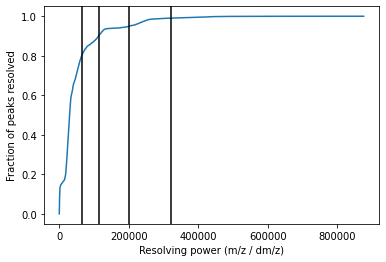

In [5]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_4.csv')

#Note, this line filters masterresults to only contain samples.
masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist.type=='sample'])]

diff_summary=[]
res_summary=[]
for time in masterresults_df['Time'].unique():
    print(time)
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():
        result_sub=result[result['File']==file]
        result_sub=result_sub['m/z'].sort_values(ascending=True)
        #mzdiff=result_sub['m/z'].sort_values(ascending=True).diff().iloc[1:]
        #mzdiff_res=result_sub['m/z'].iloc[1:]/mzdiff
        differences=result_sub.diff()


        #Resolve from peaks on either side:
        mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list(),'mz':result_sub[1:-1].to_list()})
        mzdiff_min=abs(mzdiff.min(axis=1))
        mzdiff_res=mzdiff['mz']/(mzdiff_min/2)

        diff_summary.extend(mzdiff_min.tolist())
        res_summary.extend(mzdiff_res[mzdiff_res<1e6].tolist())
        #res_summary.extend(mzdiff_res.tolist())

#print(diff_summary)

res=list(range(10,int(max(res_summary)),1000))

count=[]
for i in res:
    count.append(len([element for element in res_summary if element<i])/len(res_summary))

#print(len(diff_summary))
#print(len([element for element in diff_summary if element<0.01]))

plt.plot(res,count)
for i in [0.8,0.9,0.95,0.99]:
    current=abs(np.array(count)-i).tolist()
    print(res[current.index(min(current))])
    plt.axvline(res[current.index(min(current))],color='black')
plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

#plt.hist(diff_summary, bins=50,range=[0,.03])
#plt.xlabel('m/z diff (Da)')
#plt.ylabel('frequency')

plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

plt.show()


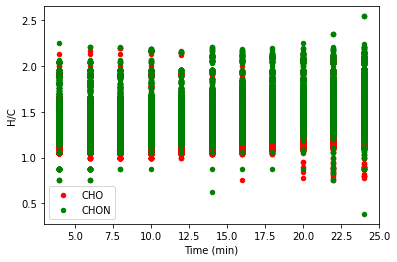

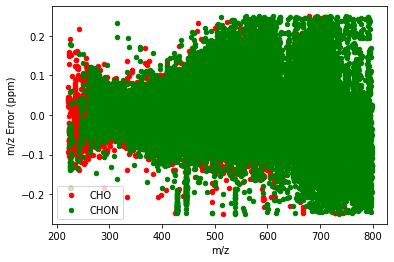

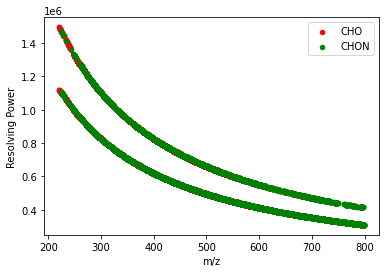

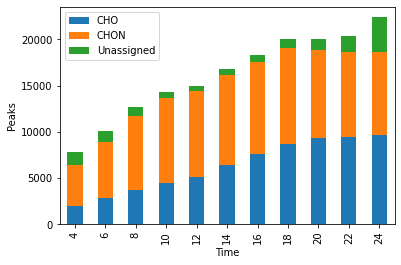

In [59]:
# Plot clean results. 
allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
#allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['N']>0.5)]='CHONS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['N']>0.5)]='CHONP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONNa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONPNa'


results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

presults=results

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)
    
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')

plt.show()


177711
14993


<AxesSubplot:xlabel='Time', ylabel='Peaks'>

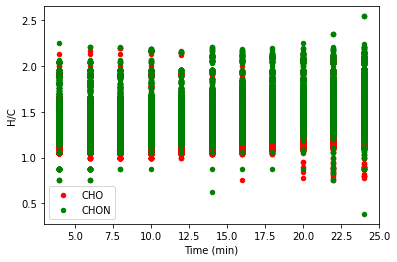

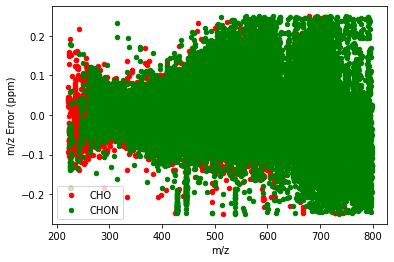

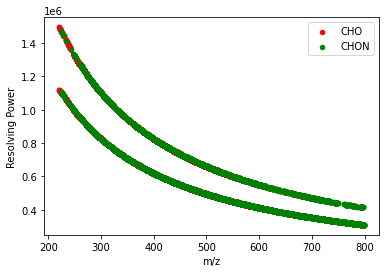

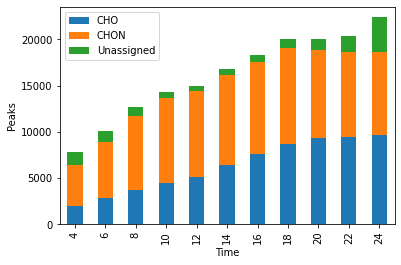

In [60]:
#Create a list of all unique features and describe their intensity. 
print(len(allresults))
#define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
uniquelist=[]
for time in allresults.Time.unique():
    current=allresults[allresults.Time==time]
    current=current.sort_values(by=['Peak Height'],ascending=False)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique[currentunique['C']>1]
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in allresults['File'].unique():
        current_file=current[current['File']==file].drop_duplicates(subset=['Molecular Formula'])
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniquelist=pd.concat(uniquelist,ignore_index=True)
print(len(uniquelist))

groups = uniquelist[uniquelist['Is Isotopologue']==0].groupby('mol_class')


colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)
    
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)

df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')


14993


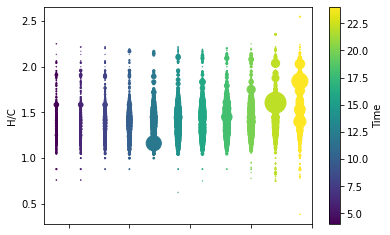

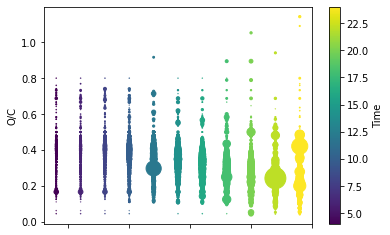

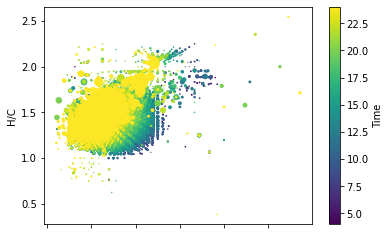

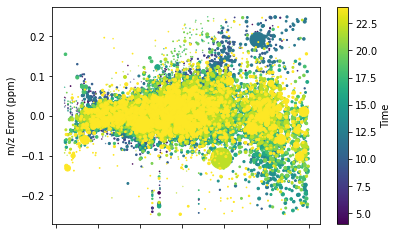

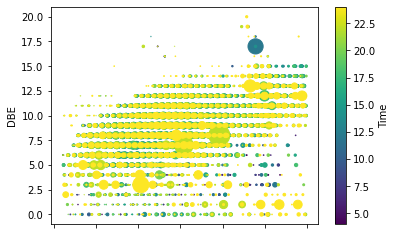

In [61]:


results=uniquelist[(uniquelist['m/z']<800)]
print(len(results))

results['N']=results['N'].fillna(0)
results['O']=results['O'].fillna(0)
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

results['mol_class']='None'
results['mol_class'][results['N']==0]='CHO'
results['mol_class'][results['N']>0.5]='CHON'
results['mol_class'][(results['O/C']<0.6) & (results['H/C']>1.32) & (results['N/C']<0.126)]='Lipid'
results['mol_class'][(results['O/C']>0.12) & (results['O/C']<0.6) & (results['H/C']>0.9) & (results['H/C']<2.5) & (results['N/C']>0.126) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
results['mol_class'][(results['O/C']>0.6) & (results['O/C']<1) & (results['H/C']>1.2) & (results['H/C']<2.5) & (results['N/C']>0.2) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Amino Sugar'
results['mol_class'][(results['O/C']>0.8) & (results['H/C']>1.65) & (results['H/C']<2.7) & (results['N']==0)]='Carbohydrate'
results['mol_class'][(results['O/C']<1.15) & (results['H/C']<1.32) & (results['N/C']>0.07) & (results['N/C']<0.126)]='Phytochemical'
#results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Oxyaromatic'


presults=results[results['Is Isotopologue']==0]

##ONLY LOOK AT CHO


groups = presults.groupby('mol_class')

#colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

#fig, ax = plt.subplots()
#ax.set_color_cycle(colors)
#ax.margins(0.05)
#for name, group in groups:
#    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
#ax.legend(numpoints=1, loc='upper left')

ax=presults.plot.scatter(x='Time',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
ax.set(xlabel='Time (min)')
presults.plot.scatter(x='Time',y='O/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='O/C',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='m/z',y='m/z Error (ppm)',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
presults.plot.scatter(x='m/z',y='DBE',s=presults['Peak Height']/4000,c='Time',cmap='viridis')

plt.show()

#presults.plot.scatter(x='Time',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='Time',y='O/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='O/C',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='m/z',y='m/z Error (ppm)',s=presults['Peak Height']/4000,c='Time',cmap='viridis')



Average Total: 9145.3
Unique good molecular formula #: 4338
Unique good molecular formula #: 0
Unique m/z peaks: 7723


<AxesSubplot:xlabel='Time', ylabel='Peaks'>

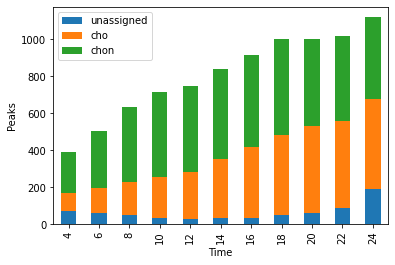

In [62]:

#Plot average number and classes of peaks assigned over time. 
nfiles=len(MSfiles)

#print(results.columns.values)
print('Average Total:', len(masterresults_df)/nfiles)
print('Unique good molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z Error (ppm)']>0.35) & (masterresults_df['m/z Error (ppm)']<1.5) & (masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

assign_summary=[]
for time in masterresults_df['Time'].unique():
    result=masterresults_df[(masterresults_df['Time']==time) & (masterresults_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    cho=len(result[(result['C']>1) & (result['N'].isnull())])/nfiles
    chon=len(result[result['N']>0])/nfiles
    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon'],stacked=True,ylabel='Peaks')


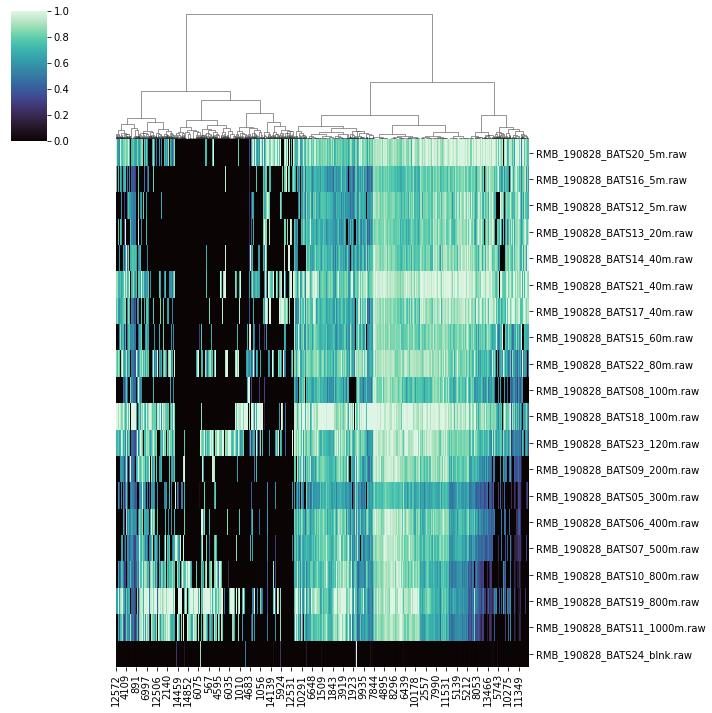

In [54]:
#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

#clustermethod='average'
clustermethod='ward'

abundances=results[masterresults_df['File'].unique()].fillna(0)

df=abundances.mean(axis=1)
df_std=abundances.std(axis=1)

p_list=[]
for ind in abundances.index:
    p=max(abs(abundances.loc[ind]-df[ind]))/df_std[ind]
    if len(abundances.loc[ind][abundances.loc[ind]>1])<2:
        p=0
    p_list.append(p)

#abundances['p']=p_list
#abundances=abundances[abundances['p']>0.1]
#abundances=abundances.sort_values(by='p',ascending=False)

results['p']=p_list

#plt.hist(p_list,bins=100,range=[min(p_list),max(p_list)])

results_clustered=results[results['p']>0.1]
norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)


cluster = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)

results_clustered['cluster']=cluster.labels_

#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clusterplot=norm_abundances
#clusterplot=clusterplot.drop(['p'],axis=1)
clusterplot=clusterplot.transpose()
clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()



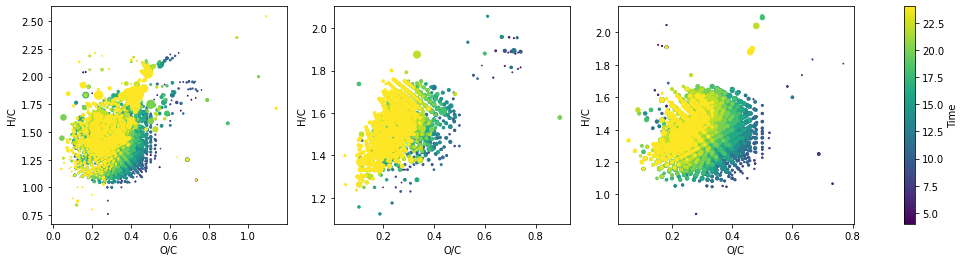

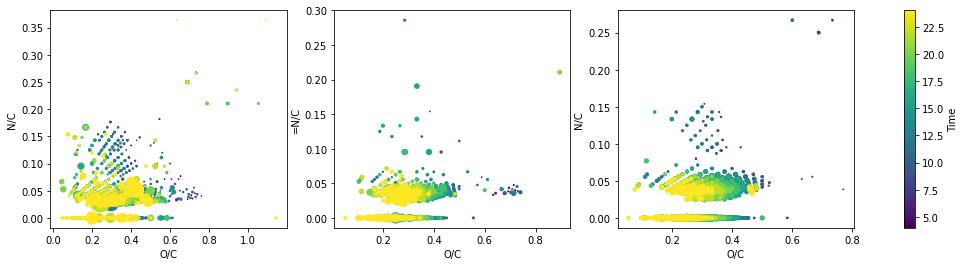

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='H/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='H/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='N/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='=N/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='N/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

plt.show()



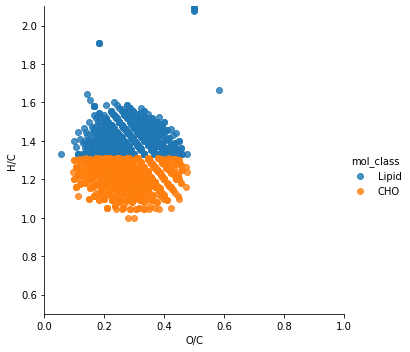

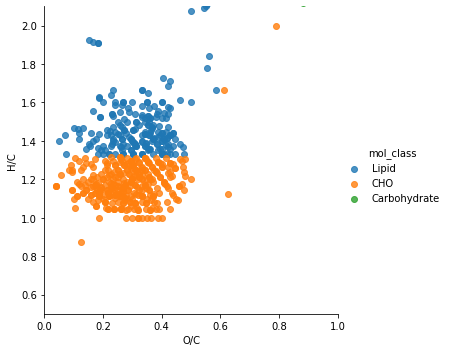

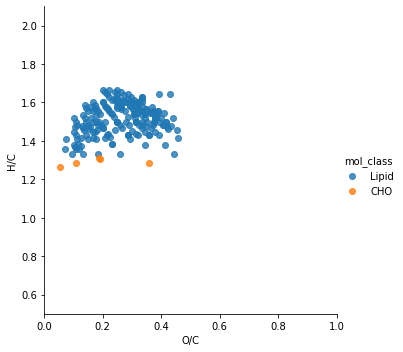

In [38]:
p1=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)], hue='mol_class', fit_reg=False)
p2=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)], hue='mol_class', fit_reg=False)
p3=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)], hue='mol_class', fit_reg=False)
p1.set(xlim=[0,1],ylim=[0.5,2.1])
p2.set(xlim=[0,1],ylim=[0.5,2.1])
p3.set(xlim=[0,1],ylim=[0.5,2.1])

plt.show()

NameError: name 'results_clustered' is not defined

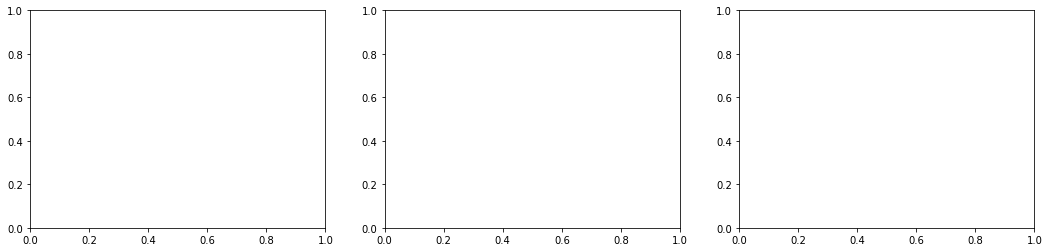

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0)]
#preresults=results_clustered[(results_clustered['cluster']>0)]
preresults=preresults[preresults['N']<0.5]

p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
ax2.scatter(x=preresults['m/z'],y=preresults['DBE'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax2.set(xlabel='m/z',ylabel='DBE')
ax3.scatter(x=preresults['m/z'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax3.set(xlabel='m/z',ylabel='H/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Cluster')



1782


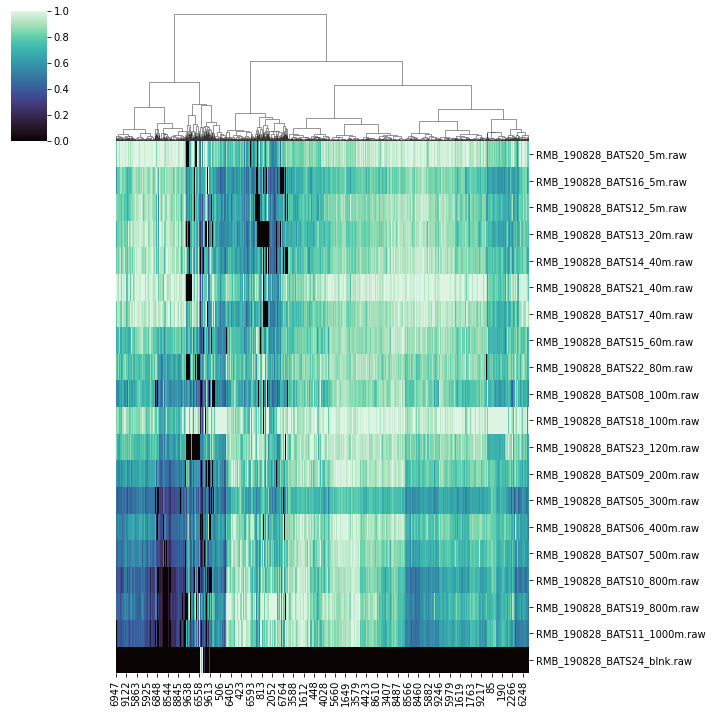

In [42]:
#Define Deep OM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==0]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

774


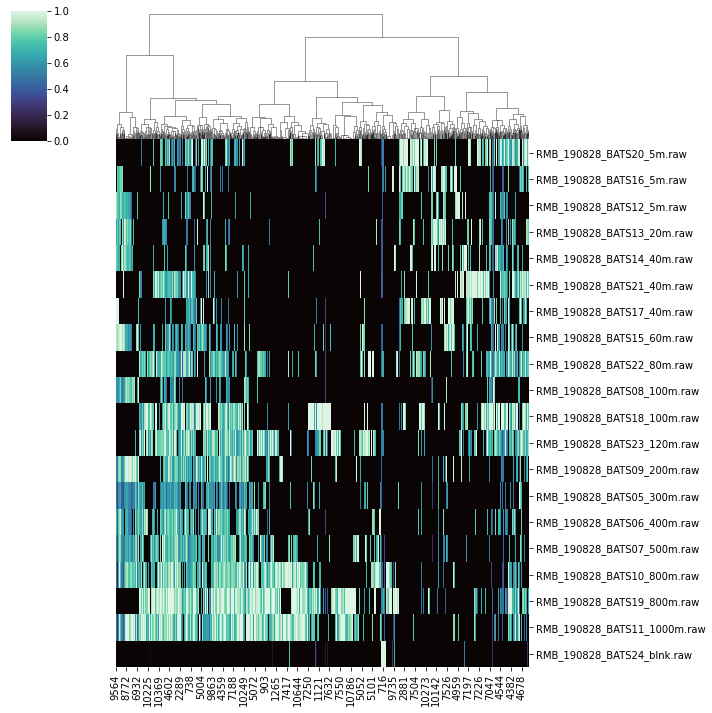

In [43]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==1]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

221


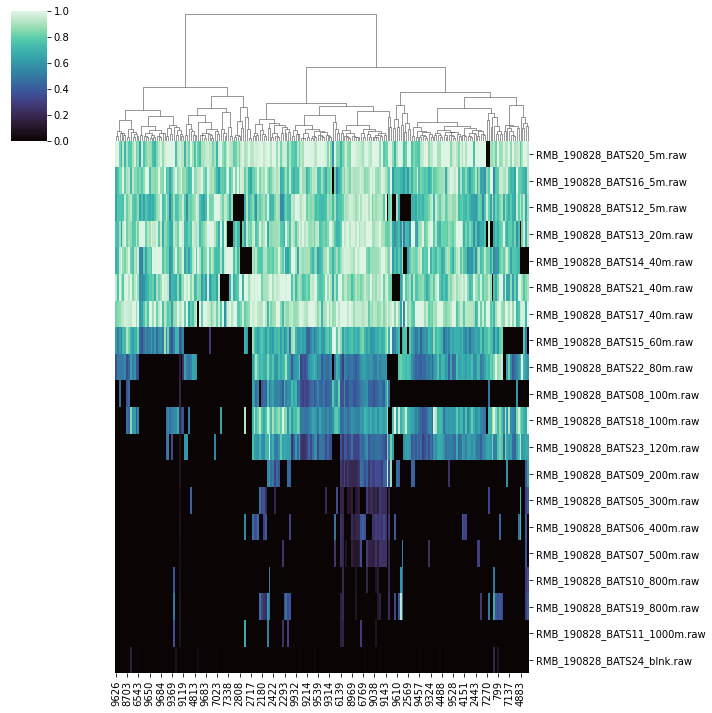

In [44]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==2]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()

print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

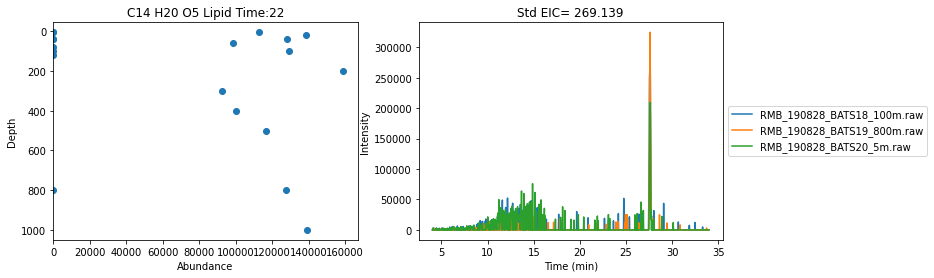

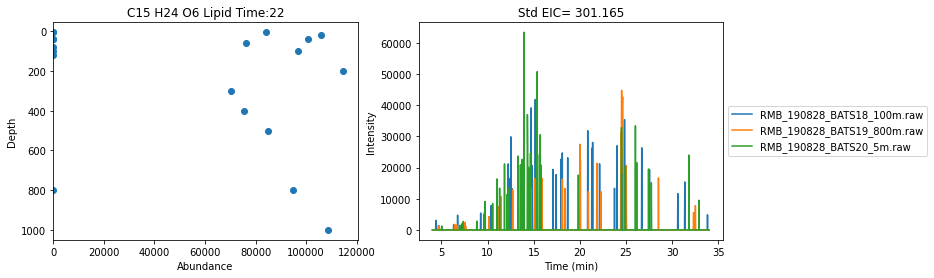

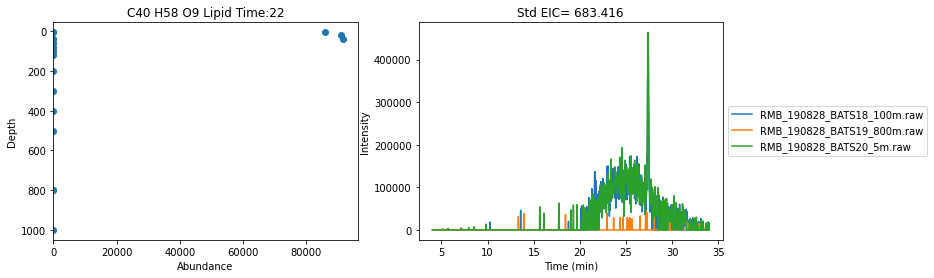

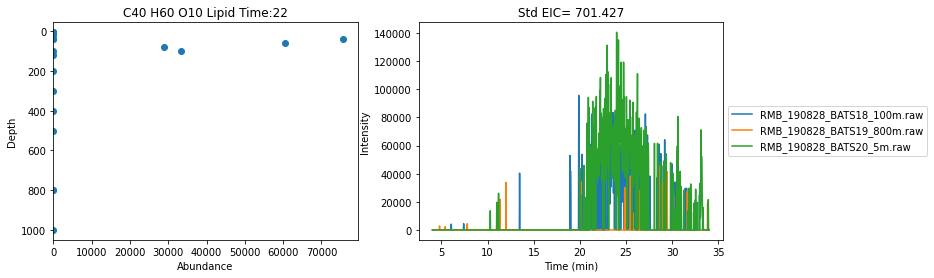

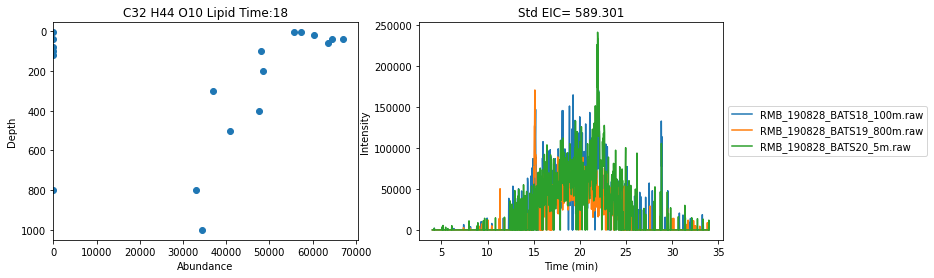

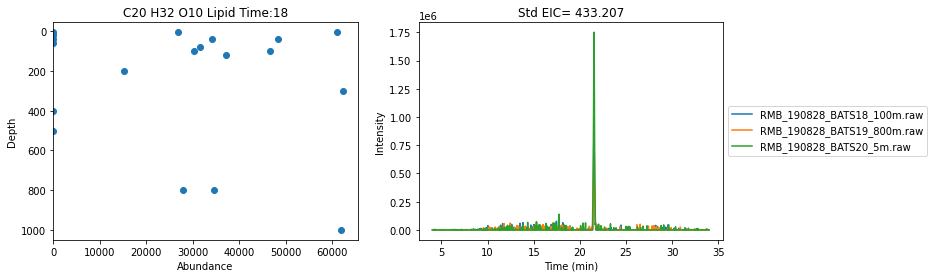

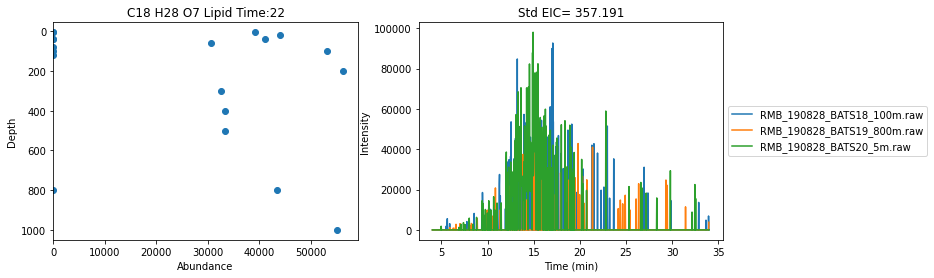

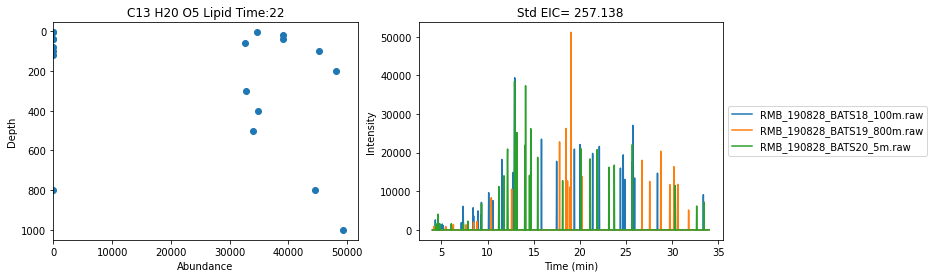

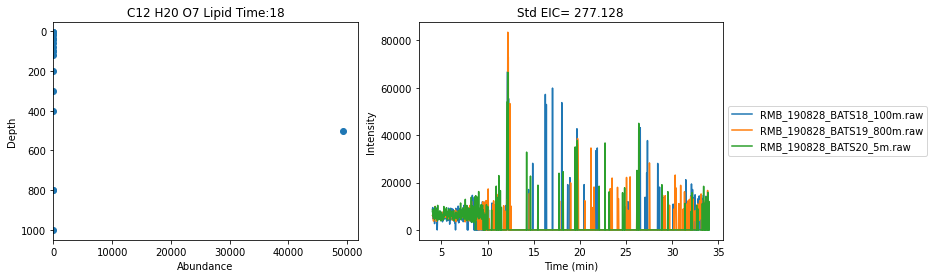

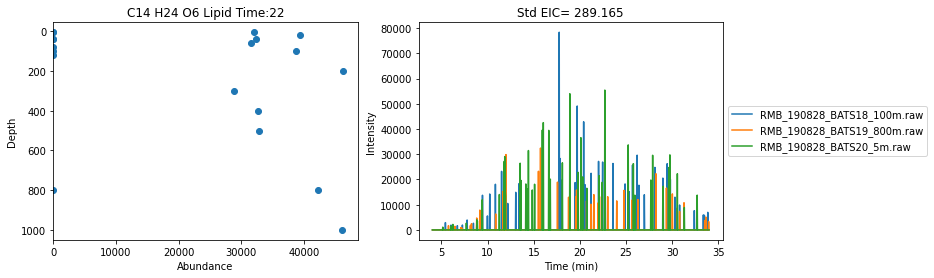

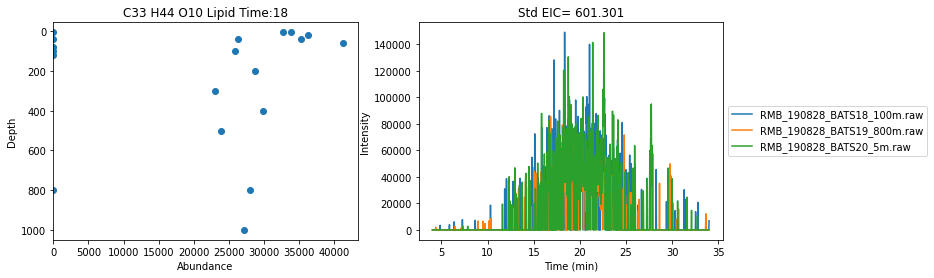

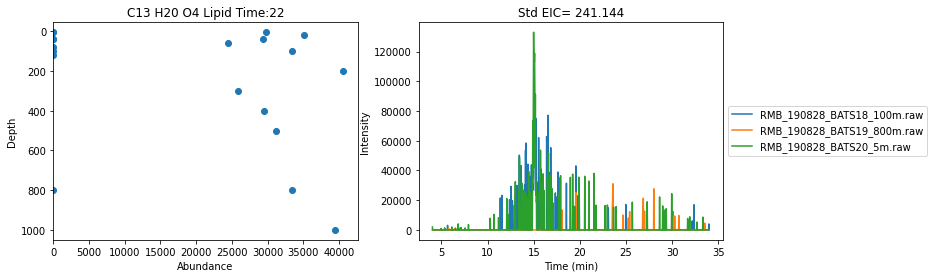

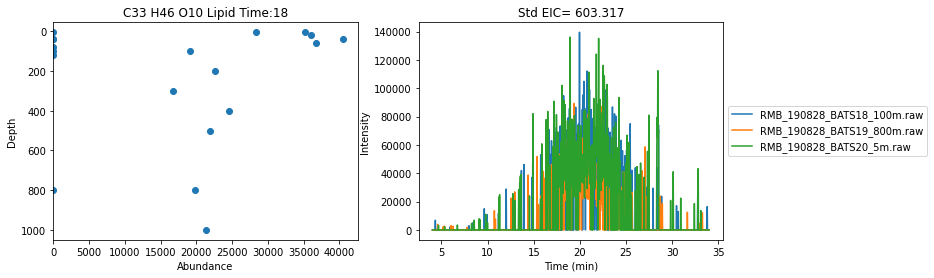

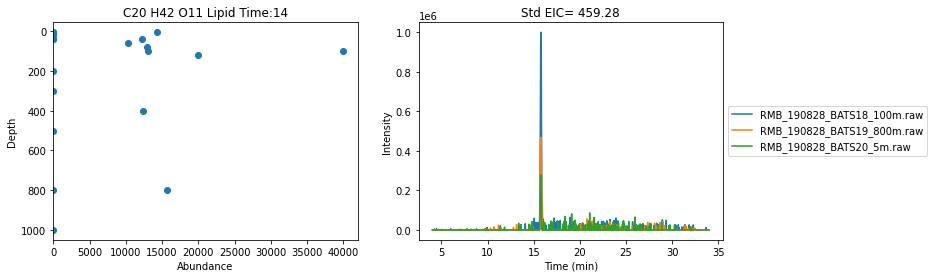

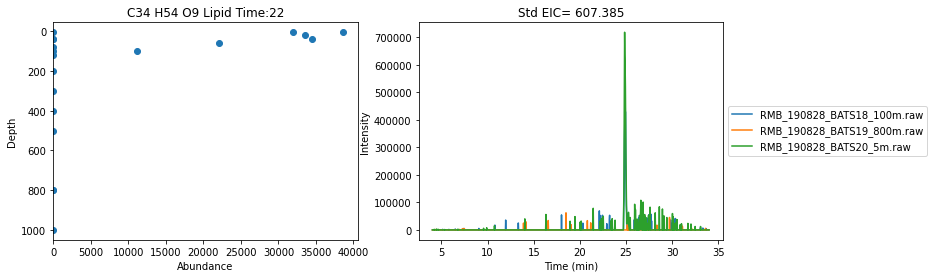

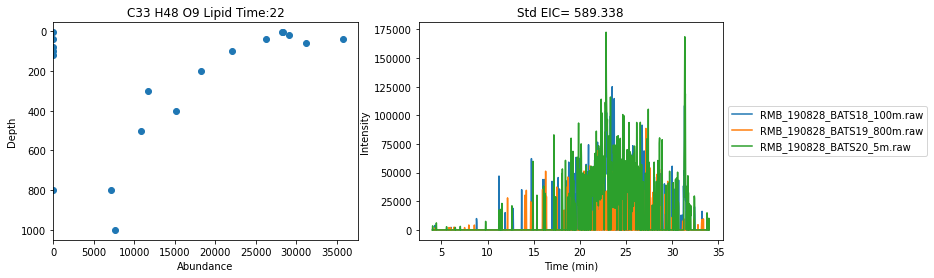

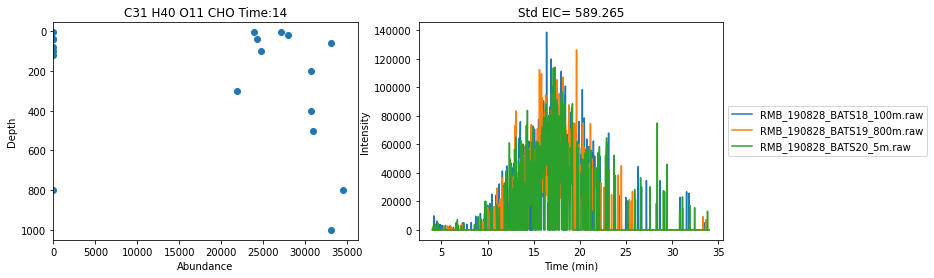

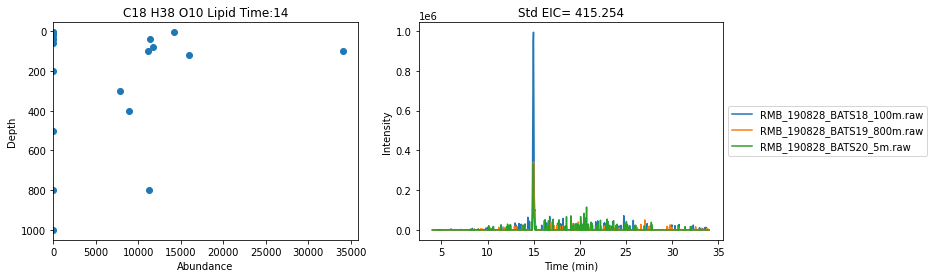

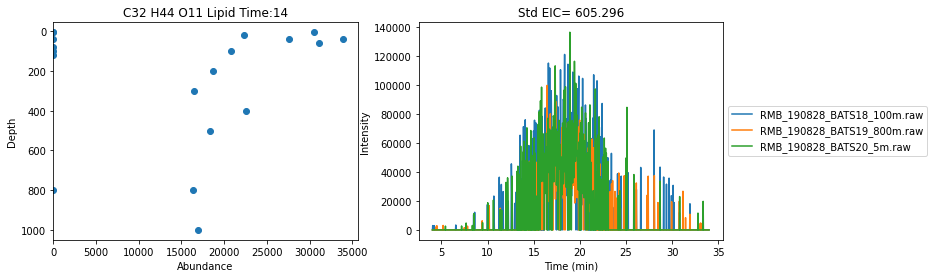

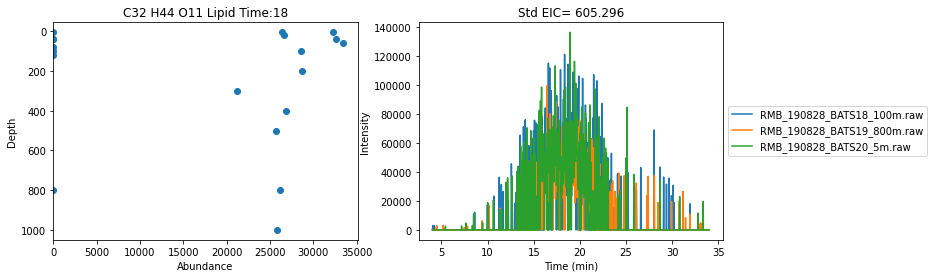

In [45]:
#Profile plotter
depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

investigate_results=results_clustered.sort_values(by='Peak Height',ascending=False)
investigate_results=investigate_results[investigate_results['cluster']==1].reset_index()

for i in range(0,20):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(4)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


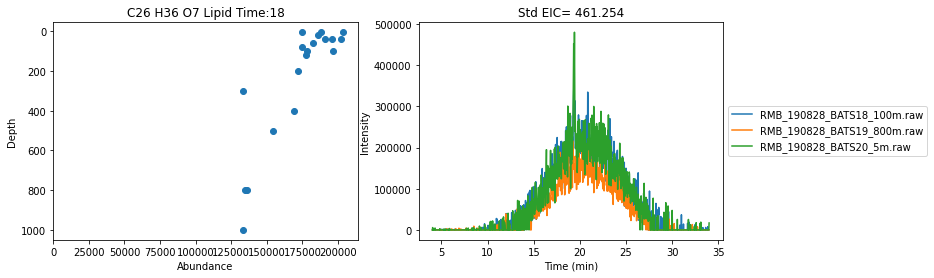

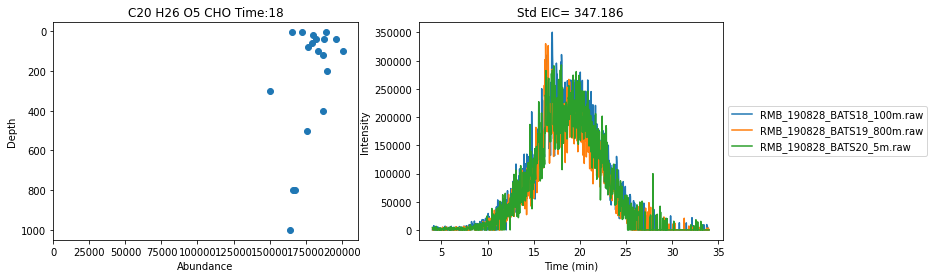

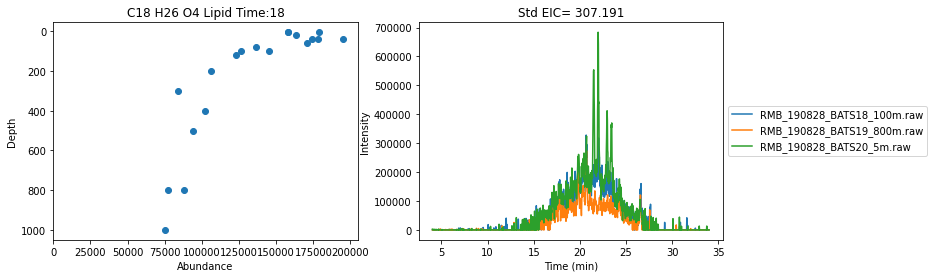

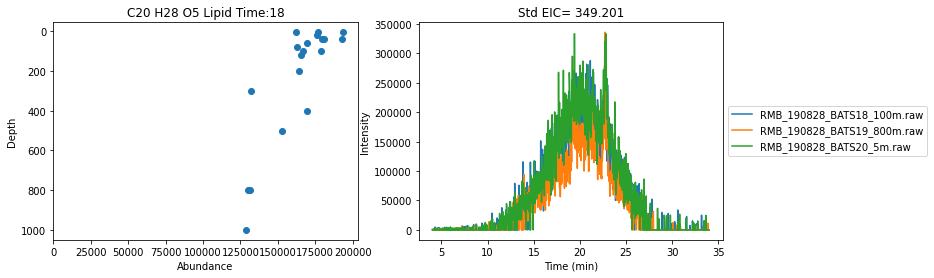

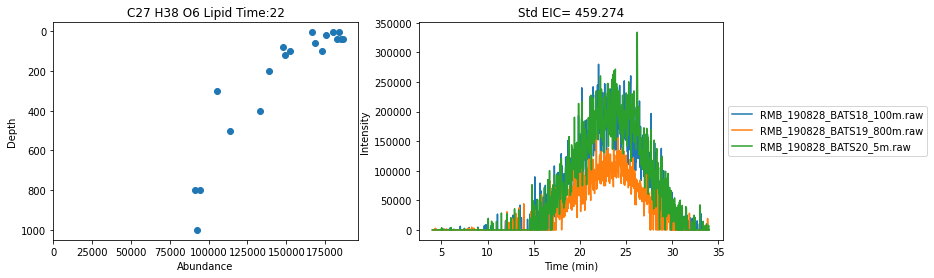

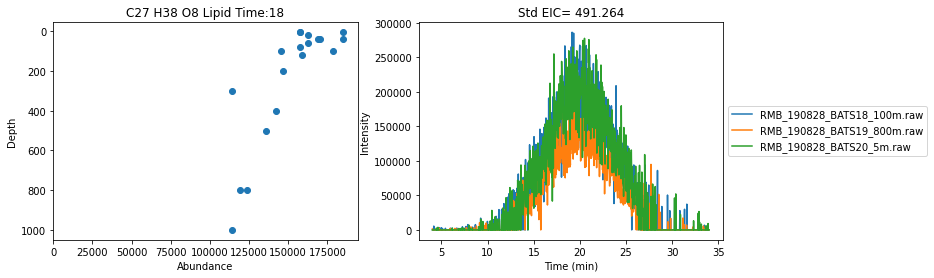

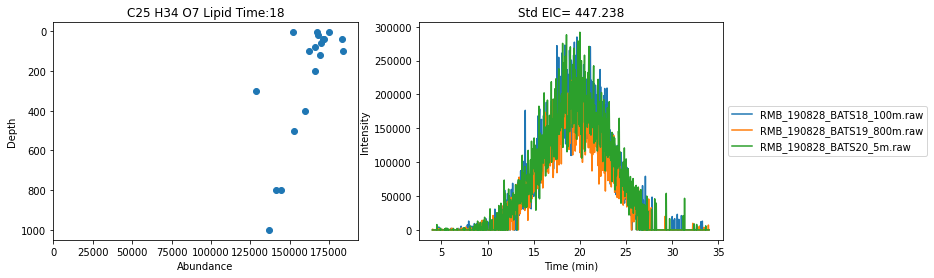

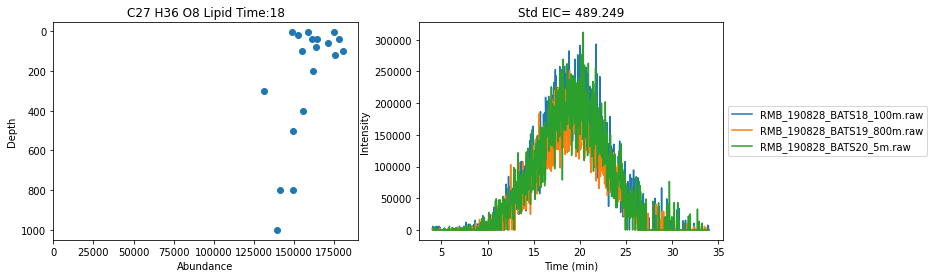

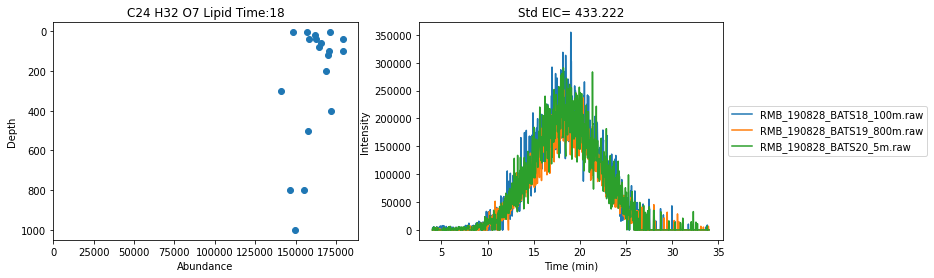

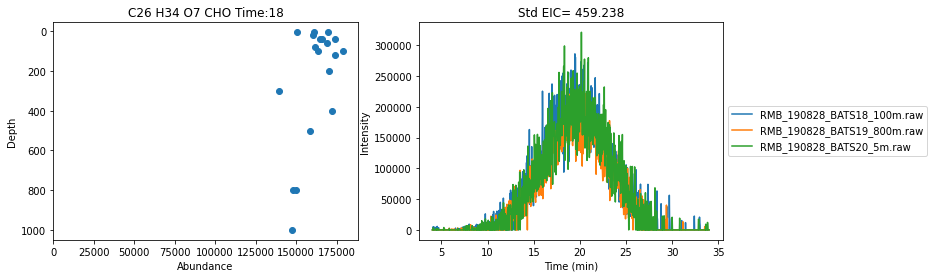

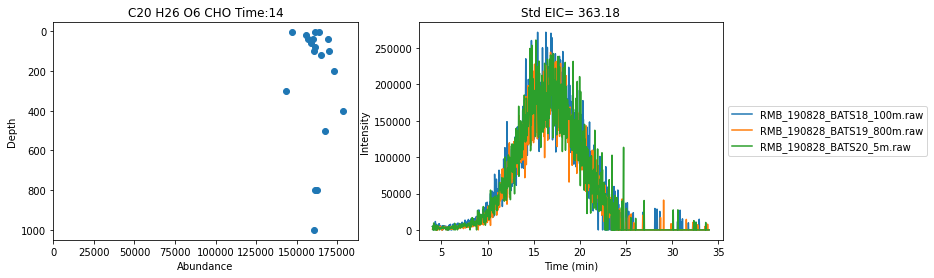

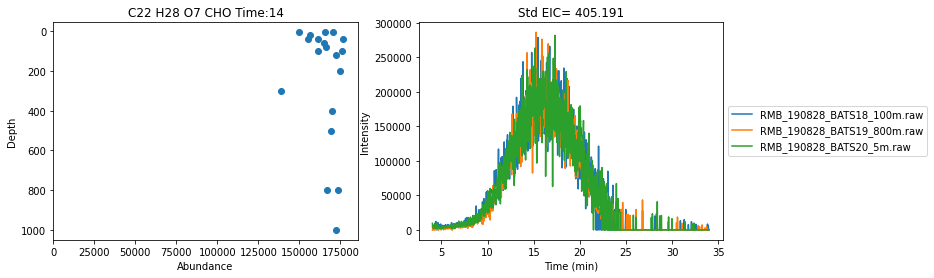

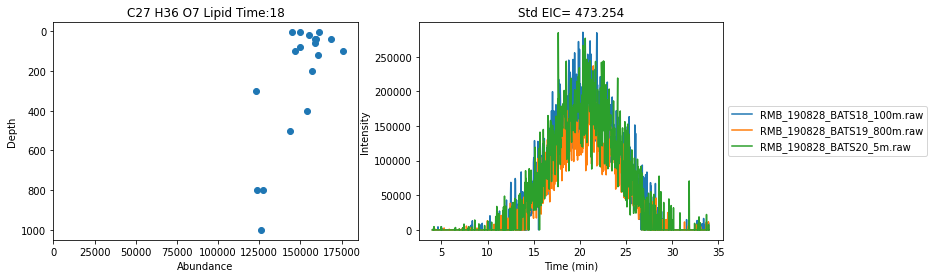

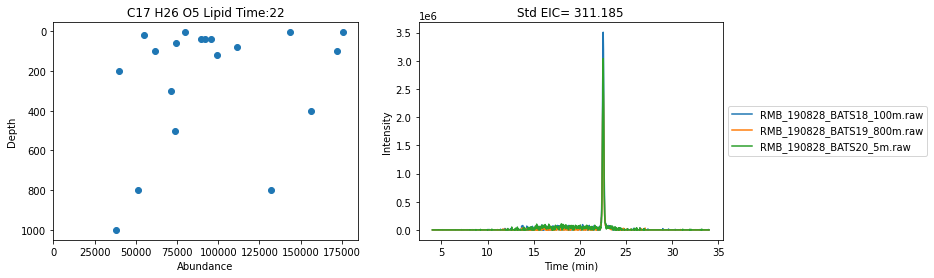

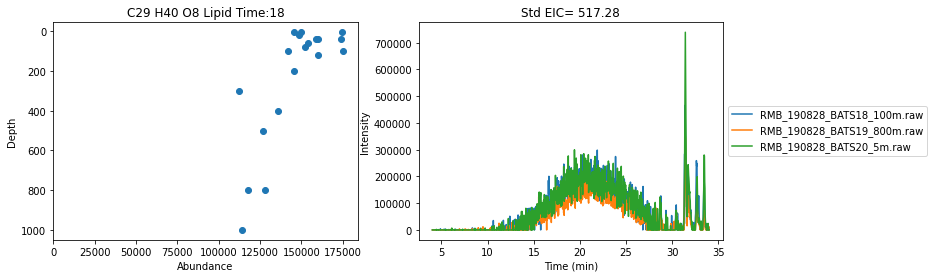

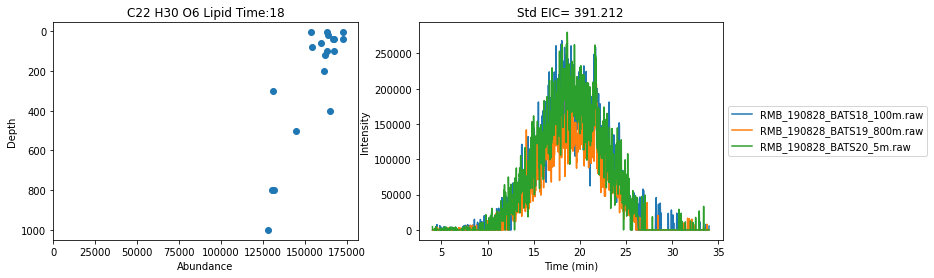

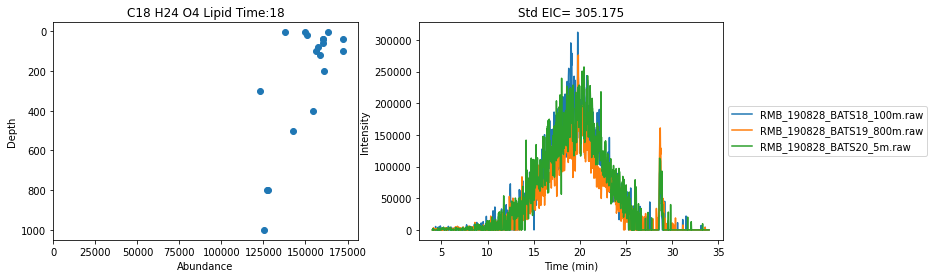

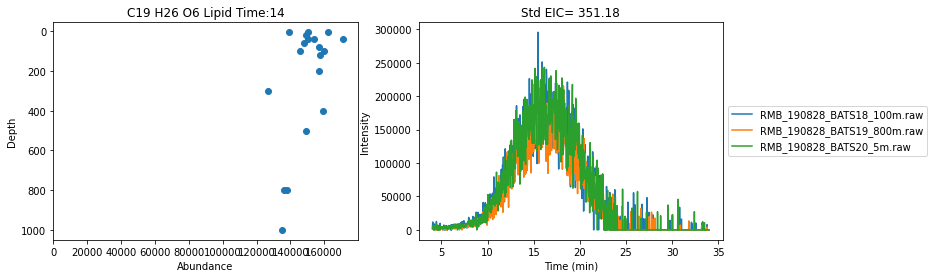

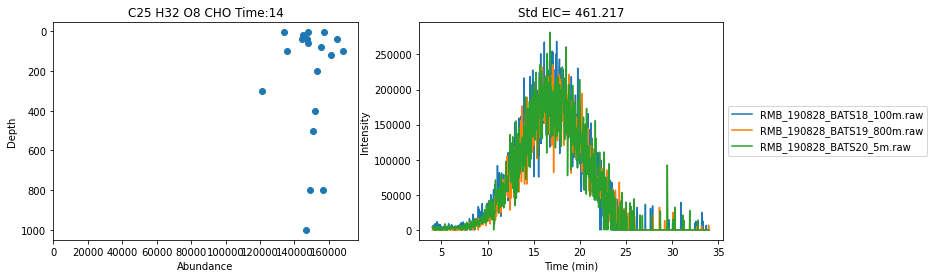

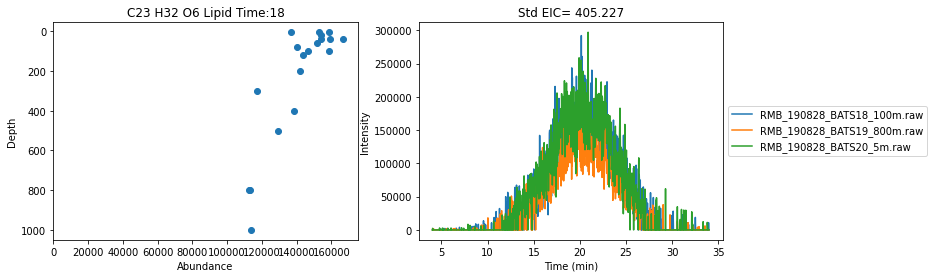

In [46]:
#Profile plotter
depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

investigate_results=results_clustered.sort_values(by='Peak Height',ascending=False)
investigate_results=investigate_results[investigate_results['cluster']==0].reset_index()

for i in range(0,20):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(3)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


In [ ]:

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

#linked = linkage(X, 'single')

#labelList = range(1, 11)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=True)
#plt.show()